In [ ]:
tf.__version__

'2.17.0'

In [ ]:
# THIS IS THE DOCUMENTATION FOR THE OVERALL TRAINING PROCESS. SOME FUNCTIONS MAY NOT BE MENTIONED HERE, BUT LATER APPEARED BELOW, THESE FUNCTIONS MAY EITHER BE NOT A
# CORE FUNCTION(ONLY DOES MINOR PROCESS LIKE TALLYING) OR VARIATION(OLD VERSIONS) OF OTHER FUNCTIONS. PARAMETERS USED FOR EACH FUNCTIONS WERE NOT MENTIONED, THESE
# EXPLANATIONS FOCUSES ON HOW IT WORKS AND THE LOGIC OF EACH FUNCTIONS. REFER TO THE FUNCTION FOR THE PARAMETERS USED.

# REFER TO fitGuide(BackUp) for all the experimental

# Current process implemented ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# pre process data from txt file converted into variable
# getting of outliers through Z-score,common length sequence,
# augmentation of data:
#   - Padding of sequences
#   - coordinates adversary augmentation ( augments the coordinates correct/base data to intentionally make it wrong, in this way we can control how sensetive our model ) -> this resovles the problem of the model needing for a perfect execution to be considered correct
#   - sequence adversary augmentation ( same thing but only this time its the seuqnce ) -> this resovles the problem of the model needing for a perfect execution to be considered correct
#   - SMOTE (this is a function that creates synthetic data from our base date to create more training data)
#   - Data partitioning (training data,validation data,2nd validation data)
#   - TRAINING (LOOP):
#        - model training with hyperparameter optimization
#        -model conversion from tf -> tflite
#        -validation with output shown
# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Data format-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Execution -> the whole exercise performed
# Sequence -> frame by frame of the execution (NOTE: MAY VARY DEPENDING ON THE PERFORMANCE OF THE DEVICE)
# Coordinates -> individual coordinates that represents the location of each parts of the body

# 66 coordinates:
# 0 -> Nose                     17 -> left pinky
# 1 -> left eye inner           18 -> right pinky
# 2 -> left eye                 19->left index
# 3  -> left eye outer          20 -> right index
# 4 -> right eye inner          21 -> left thumb
# 5 -> right eye                22 -> right thumb
# 6 -> right eye outer          23 -> left hip
# 7 -> left ear                 24 -> right hip
# 8 -> right ear                25 -> left knee
# 9 -> mouth left               26 -> right knee
# 10 -> mouth right             27 -> left ankle
# 11 -> left shoulder           28 -> right ankle
# 12 -> right shoulder          29 -> left heel
# 13 -> left elbow              30 -> right heel
# 14 -> right elbow             31 -> left foot index
# 15 -> left wrist              32 -> right foot index
# 16 -> right wrist

# This is how coordinates are divided into:
# left arm -> [11,13,15]
# right arm -> [12,14,16]

# body -> [11,23,12,24,]

# left leg -> [23,25,27]
# right leg -> [24,26,28]

# head -> [4,1,10,9] (not really sure on this part...need to review but 4 coordinates was use on this)

# NOTE: all of the coordinates are all being used in the process although some of it are irrelevant. Future iteration should take into account this to lessen the training time and complexity
# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# HOW DOES PRE PROCESS DATE FROM TXT FILE TO VARIABLE WORK?:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# START is where the execution starts
# END is where the execution ends
# Sequences are the lines in between END and START
# Coordinates are separted by |

# EXAMPLE:
# START  <--------------------------------  start of the executions
# 0.5|0.756|0.6456|0.34  <----------------- individual sequences
# 0.5|0.756|0.6456|0.34  <----------------- | separates individual coordinates
# 0.5|0.756|0.6456|0.34
# 0.5|0.756|0.6456|0.34
# END   <--------------------------------  end of the executions

#VVVVVVVVVVVVVVVVVVVVVVVVVVVVVV--[CONVERSION]--VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
# 0.5|0.756|0.6456|0.34  ==  [0.5,0.756,0.6456,0.34] <-------sequences and individual coordinates

# 0.5|0.756|0.6456|0.34----|
# 0.5|0.756|0.6456|0.34    |
# 0.5|0.756|0.6456|0.34    |------------> [[0.5,0.756,0.6456,0.34],[0.5,0.756,0.6456,0.34],[0.5,0.756,0.6456,0.34],[0.5,0.756,0.6456,0.34]]   <---- this is one execution
# 0.5|0.756|0.6456|0.34----|
# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# HOW DOES OUTLIER DETECTION(COMMON LENGTH SEQUENCE) WORK?--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Introduction: this removes the outlier of the executions based on the amount of sequence length
# why do this?: this removes potential executions that were accidentally created when collecting data and also removes inconsistency. This creates a better model if done well but we should also be cautious about it since if we were to remove exesively then we would loose vital data.

# EXAMPLE
#  Threshold -> 2(default=5) - this is the threshold of the frequency if it is below this threshold then it would be considered as an outlier
#  [4,3,6,7,3,1,6,8,9,4,6,3,4] - sample number of length

# freuency found:
#  length  |   frequency
#    4            3
#    3            3
#    6            3
#    7            1
#    1            1
#    8            1
#    9            1
# outlier -> 9,8,1,7
# common ->4,3,6
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# HOW DOES OUTLIER DETECTION(Z-SCORE) WORK?----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Introduction:This removes the outlier of the executions based on the z-score value of each distinct seuqnce length.
# Why do this?: Same with Common Length Sequence, it removes accidentally created data when collecting and also removes inconsisency.

# Example:
# [2,4,5,6,9,10] -> distinct length value
# z-scord theshold -> 1 (default=1)
# standard deviation -> 2.77 (please verify not sure about the value)
# mean -> 6
# distinct length | z-score
# 2 ---- 1.44
# 4 ---- 0.72
# 5 ---- 0.36
# 6 ---- 0
# 9 ---- 1.08
# 10 ---- 1.44

# [4,5,6] <--- remaining data with this length
# [2,9,10] <--- removed data with this length
# -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# HOW DOES PADDING WORK?:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Introduction : not all executions have the same sequences/frame which means each executions may vary in the duration of the execution
# why do this? : model only accepts the amount of length predefined before training. In order to take into account varied length of sequences padding is necessary.
# Example:
#   0 --> coordinates
#   [] ---> sequences
#   {} ---> executions
# {[0,0,0],[0,0,0],[0,0,0]} <--------------------- 3 sequences (fast execution)
# {[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0]} <----- 5 sequences (slow execution)
# {[0,0,0],[0,0,0],[0,0,0][0,0,0]} <-------------- 4 sequences (normal speed execution)
#
# if padding is applied
#  we get the max length of all the execution to set as basis for every sequences
# X ---> dummy value from padding

# {[0,0,0],[0,0,0],[0,0,0],[X,X,X],[X,X,X]}
# {[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0]}
# {[0,0,0],[0,0,0],[0,0,0],[0,0,0],[X,X,X]}
# -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# HOW DOES COORDINATES ADVERSARY AUGMENTATION WORK? -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Introduction : this is to address of the preverious issue of the model sensetivity to data ( would only output correct if input execution is pixel perfect to what it was trained). A function will randomly pick a coordinate and give new value to it based on the specification
# why do this? : 1) to create more data both correct and incorrect execution 2)in order for the model to be more forgiving on the execution (or we can manipulate how sensetive it is)

# suppose we have a single coordinate value of 0.5 we can specify the augmentation to +-0.05 soo possible value for the new augmented data would be in the range of 0.45 - 0.55
# by specifying small value for augmentation we can create new correct data with slight difference in coordinates.
# on the other hand if we specify large value for augmentation we can create incorrect data.

# Example:
#   0 --> coordinates
#   [] ---> sequences
#   {} ---> executions
#   q ----> Minor augmentation of coordinates
#   Q ----> Major augmentation of coordinates

# {[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0]} <------- base data / correct data
# {[0,0,q],[0,0,q],[q,q,0],[0,0,q],[q,0,q]} <------- minor coodinate augmented(still somehow correct data) = coordinates
# {[0,0,Q],[0,0,Q],[Q,Q,0],[0,0,Q],[Q,0,Q]} <------- major coodinate augmented(incorrect data)
# -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# HOW DOES SEQUENCE ADVERSARY AUGMENTATION WORK?---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Introduction: This is the same with coordinates aversary augmentation but this time it will be with sequences. This randomly picks a sequence in between the first and last sequence then replace it with sequence containing "0" coordinates.
# why do this? : 1) to create more data both correct and incorrect execution 2)in order for the model to be more forgiving on the execution (or we can manipulate how sensetive it is)

# Example:
#   0 --> coordinates
#   [] ---> sequences
#   {} ---> executions
#   () ---> augmenteed sequence

# {[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0]} <------- base data / correct data
# {[0,0,0],[0,0,0],[0,0,0],(0,0,0),[0,0,0]} <------- minor augmentation(still somehow correct data)
# {[0,0,0],[0,0,0],(0,0,0),(0,0,0),[0,0,0]} <------- major augmentation(incorrect data)
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# HOW DOES SMOTE WORK?-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Introduction: SMOTE is a function from a package that creates synthetic data to balance out groups of data.
# why do this?: to have more data to be used in the model and to balance out the correc and incorrect data.

# Example:
# currently dont have any idea of the inner workings of the funciton, refer to the actual code for how its use
# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# HOW DOES HYPERPARAMETER OPTIMIZATION WORKS?--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Introduction: Hyperparameter optimization revolves around adjusting the parameters based on its previous result. This would loop for a certain amount of time to try and find the best parameter for the model.
# Why do this?: to alleviate us from having to adjust the parameter by ourselves, by doing so we can have a dynamic training for each data.

# PARAMETERS
# Units -> number of neuron of layer (possible value = int)
# Return sequence -> takes into account the previous sequence and the present sequence (possible value = boolean)
# Dropout rate -> number of neurons to drop randomly (possible value = double)
# Recurrent Dropout Rate ->  number of neurons to drop randomly in terms of sequence check(i guess?????)(possible value = double)
# learning rate -> rate of leaning of the model (possible value = double)


# Example:
# define a value range for parameters. This would be the value limit of the hyperparamters when adjusting.

# X ---> First range
# Y ---> second range

# Q  ---> List of choices

# units = trial.suggest_int(f'lstm_units_layer_{i}', X, Y)
# return_sequences = trial.suggest_categorical(f'lstm_return_sequences_layer_{i}', [Q, Q])
# dropout_rate_value = round(trial.suggest_float(f'lstm_dropout_layer_{i}', X, Y)  , 2)
# recurrent_dropout_rate_value = round(trial.suggest_float(f'lstm_recurrent_dropout_layer_{i}', X, Y), 2)
# learning_rate = trial.suggest_float('learning_rate', X, Y)
# -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
# possible researches
# layers -> combining LSTM and bidirectional, bidirectional only, LSTM only,
# augmentations -> number of augmentation, range of augmentation
# SMOTE -? if smote is present, and if SMOTE is not used
# luminance -> low light, mid light, bright light
# distsance -> close(perfectly fit on the screen) to far

# CURRENT PROBLEMS:
# training takes a very long time even with colab (CURRENT SOLUTION -> lessen the hyperparameter optimization, limited it into 10 loops currently)
# SMOTE creates lots of data increasing the training time (PROPOSED SOLUTION -> LESSEN AUGMENTATION AND LESSEN REQUIRED DATA TO BE COLLECTED(CURRENTLY SUGGESTED -> ATLEAST 50 EXECUTIONS))



# -----------------------------------------------------------------DOCUMENTATION-------------------------------------------------------------------------------------
# tried lowering the number of data after SMOTE, lowered it down to 35% only and the accuracy lowered down significantly to an average og 65% ---- time in between training is also almost the same(not verified yet but feels like it)
# soo far SMOTE showing significant increase to accuracy but it creates more synthetic data therefore introduces more training time.

# luminance level(brightness of environment) could potentially affect the performance of the app. The darker the environment the lesser the accuracy of Pose Estimation. It jittery or erratic when showing the Pose Estimation Skeleton.
# basis for this is the confidence level function of tflite, it dips down below 90% if environment gets darker






In [ ]:
!pip install tensorflow==2.10

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 93.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 50.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  At

In [ ]:
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, BatchNormalization,SimpleRNN,Conv1D, MaxPooling1D, Flatten,Dropout
from tensorflow.keras.callbacks import TensorBoard,ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import tensorflow as tf
from keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam

import copy
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

from tensorflow.keras.regularizers import l1, l2

from tqdm import tqdm

import numpy as np
import cv2

from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_curve, auc



# from tensorflow_model_optimization.quantization.keras import quantize_model
from collections import Counter
import random as rand
import os


# run this if using google colab
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.8 MB/s eta 0:00:00


In [ ]:
import numpy as np

# [CURRENTLY BEING USED]
# This function converts txt file into variable that can be use (^^^^refer above for how txt file are arranged and converted)
# PARAMETERS:
# txt_file -> txt file location
# label( 0 or 1 ) -> this is for classification ( if the txt file contains the correct executions then assign it as 1 and wrong as 0)
# Simplify(True or False) -> this determines whether to simplify the coordinates value by taking away certain amount of decimal places
# simplify_level -> this determines the amount of decimal places to remove

def txt_pre_process(txt_file,label,simplify=False,simplify_level=5 ):
    label_array = []
    temp_feature_data = []
    temp_sequence_data = []
    batch_data = []

    # Opens the text file
    with open(str(txt_file), 'r') as file:

      # splits the coordinates using the delimiter
        for line in file:
            values = line.strip().split('|')

            temp_feature_data = []

            for value in values:
                float_value = str(value)

                # Checks for START string, this signifies a start to another data
                if float_value == 'START':
                    temp_sequence_data=[]
                # Checks for END string, the end of the data, and will be compiled into the array
                elif float_value == 'END':
                  # Compiles all sequences into one execution
                    batch_data.append(temp_sequence_data)
                    label_array.append(label)

              # Simplifies the data by decreasing the amount of decimal.
                elif float_value != '' and float_value != 'START':
                    if simplify:
                        float_value = round(float(value),simplify_level)
                    else:
                        float_value = float(value)
                    temp_feature_data.append(float_value)

            # Compiles all coordinates into one sequence.
            if temp_feature_data!=[]:
                temp_sequence_data.append(temp_feature_data)

    label_array = np.array(label_array)

    return [batch_data,label_array]


def txt_pre_process2(txt_file,label,simplify=False,simplify_level=5 ):
    label_array = []
    temp_feature_data = []
    temp_sequence_data = []
    batch_data = []

    # Opens the text file
    with open(str(txt_file), 'r') as file:

      # splits the coordinates using the delimiter
        for line in file:
            values = line.strip().split('|')

            temp_feature_data = []

            for value in values:
                float_value = str(value)

                # Checks for START string, this signifies a start to another data
                if float_value == 'START':
                    temp_sequence_data=[]
                # Checks for END string, the end of the data, and will be compiled into the array
                elif float_value == 'END':
                  # Compiles all sequences into one execution
                    batch_data.append(temp_sequence_data)
                    label_array.append(label)

              # Simplifies the data by decreasing the amount of decimal.
                elif float_value != '' and float_value != 'START':
                    if simplify:
                        float_value = round(float(value),simplify_level)
                    else:
                        float_value = float(value)
                    temp_feature_data.append(float_value)


            # Compiles all coordinates into one sequence.
            if temp_feature_data!=[]:
                temp_sequence_data.append(temp_feature_data)
                temp_sequence_data.append(temp_feature_data)
                temp_sequence_data.append(temp_feature_data)


    label_array = np.array(label_array)

    return [batch_data,label_array]


# This function puts a dummy sequences at the end to satisfy the amount of sequences needed for the model or to convert the sequence count uniformly
# pre_processed_input -> this parameters is for the data input
# optional_maxLength -> by assigning a value here we can specify the amount of sequence length
def padding(pre_processed_input,optional_maxLength=0):
    padded_sequences = []

    # optional maxlength sequence(specified by user)
    if optional_maxLength != 0:
        max_length = optional_maxLength
    else:
      # retrieves the maximum length of the dataset
        max_length = max(len(sequence) for sequence in pre_processed_input)

    for sequence in pre_processed_input:
        padding_length = max_length - len(sequence)
        if padding_length >= 0:
            padded_sequence = np.pad(sequence, ((0, padding_length), (0, 0)), mode='constant')

        else:
            padded_sequence = sequence[:max_length]
        padded_sequences.append(padded_sequence)
    padded_sequences = np.array(padded_sequences)

    return padded_sequences

# [CURRENTLY BEING USED]
# This function combines sets of executions in a randomized order
# base_input -> executions data input
# base_label -> label of executions data input
# concat_input -> 2nd set of executions data input
# concat_label -> 2nd set of label of executions data input

def concatenate_randomize_batches(base_input,base_label,concat_input,concat_label):
  # combining inputs and label as one array
    combined_inputs = np.concatenate((base_input,concat_input), axis = 0)
    combined_label = np.concatenate((base_label,concat_label), axis = 0)

    # gets the random seed for randomizing
    indices = np.random.permutation(len(combined_inputs))

    # uses the random seed to randomize input
    randomized_inputs = combined_inputs[indices]
    randomized_label = combined_label[indices]

    return [randomized_inputs,randomized_label]




def tally_sequence(sequence_array):
    tally_number = []
    tally_ctr = []

    for x in sequence_array:
        temp = len(x)
        if temp not in tally_number:
            tally_number.append(temp)
            tally_ctr.append(1)
        else:
            for y in range(len(tally_number)) :
                if temp == tally_number[y]:
                    tally_ctr[y] = tally_ctr[y] + 1

    tally_max = 0
    tally_number_arranged = []
    tally_ctr_arranged = []

    for x in range(len(tally_number)):
        # print(len(tally_ctr))
        tally_max = max(tally_ctr)
        for y in range(len(tally_number)):
            if tally_ctr[y] == tally_max:
                tally_number_arranged.append(tally_number[y])
                tally_ctr_arranged.append(tally_ctr[y])
                tally_ctr.pop(y)
                tally_number.pop(y)
                break

    total_ctr = 0
    for x in tally_ctr:
        total_ctr = total_ctr + x


    for x in range(len(tally_number_arranged)):
        print(tally_number_arranged[x],'-->',tally_ctr_arranged[x])

# [CURRENTLY BEING USED]
# this function is an outlier detection for sequence length by going through every executions and checking the length of sequence
# sequences_array -> data input(NOTE!: data input that have not used the padding function)
# threshold -> this determines the minimum frequency of the sequence length

def common_length_sequence(sequences_array,threshold = 5):
    temp = []
    data = [len(seq) for seq in sequences_array]
    data_frequency = Counter(data)
    most_common_data = data_frequency.most_common()

    # if the sequence or frame by frame falls below the threshold it is appended in this array
    outlier_frequencies = [value for value, freq in data_frequency.items() if freq < threshold]

    # if sequence is above the threshold it is appended in this array
    most_common_values = [value for value, freq in most_common_data if freq >= threshold]



    # Executions that have common length is collected
    for x in sequences_array:
        if len(x) in most_common_values:
            temp.append(x)

    print("Most Common Data Points:", most_common_values)
    print("Outlier Frequencies:", outlier_frequencies)

    print('-------------------applied frequency outlier detection-------------------')
    print("original num -> ", len(sequences_array))
    print("current num -> ", len(temp))
    print("removed num -> ", len(sequences_array) - len(temp))

    return temp

# [CURRENTLY BEING USED]
# This function is an outlier detection for z-score and as seuqnce length as basis
# sequences_array -> executions data input
# z_score_threshold -> determines the minimum amount of Z-score

def apply_z_score(sequences_array,z_score_threshold = 1):
    data_points = []
    included_datapoints = []
    updated_sequences =[]

    for x in sequences_array:
        temp = len(x)
        if temp not in data_points:
            data_points.append(temp)

    data = np.array(data_points)
    mean_value = np.mean(data)
    standard_deviation = np.std(data)
    z_scores = (data - mean_value) / standard_deviation
    for x in range(len(z_scores)):
        if np.abs(z_scores[x]) <= z_score_threshold:
            included_datapoints.append(data[x])


    for x in sequences_array:
        if len(x) in included_datapoints:
            updated_sequences.append(x)
    print('-------------------applied z-score outlier detection-------------------')
    print("datapoints included -> ", included_datapoints)
    print("original num -> ", len(sequences_array))
    print("current num -> ", len(updated_sequences))
    print("removed num -> ", len(sequences_array) - len(updated_sequences))

    return updated_sequences

# [CURRENTLY BEING USED]
# this function is an outlier detection for sequence length by going through every executions and checking the length of sequence
# sequences_array -> data input(NOTE!: data input that have not used the padding function)
# threshold -> this determines the minimum frequency of the sequence length
def paddingV2(sequences_array_input,optional_maxlength = 0):
  # copies the input array
    sequences_array = copy.deepcopy(sequences_array_input)

    output = []
    max_length = 0

    padding_length_before = 0
    padding_length_after = 0

    # optional user input for max length
    if optional_maxlength == 0:
        # getting the maximum sequence value of all data
        max_length = max(len(sequence) for sequence in sequences_array)
        expanded_max_length = int(max_length+ ((max_length) * .10))
    else:
        expanded_max_length = optional_maxlength

  # padding process
    for seq in sequences_array:
      # This loop is based on the difference of max sequence and data number of execution.
        for x in range(expanded_max_length-len(seq)+1):

          # This dictates where the padding goes, each loop, data will be padded differently
            padding_length_before = x
            padding_length_after = expanded_max_length - len(seq) - x

            # padding of sequences by inputing a sequence that contains 66 coordinate of value 0
            padded_sequence = np.pad(seq, ((padding_length_before, padding_length_after),(0,0)), mode='constant')
            # compiling
            output.append(padded_sequence)

    print('------------------------applied paddingV2------------------------')
    print('max_length -> ', max_length)
    print('expanded_max_length -> ', expanded_max_length)
    print('original num set of sequences -> ', len(sequences_array))
    print('final num set of sequences -> ', len(output))

    output = np.array(output)
    return output


# [CURRENTLY BEING USED]
# This function converts tf models into tflite models and save then saves it.
# tf_model -> tf model input
# input_shape -> specifies the input shape of the data input for the model(need to review on this one)
# test_dataset -> sets of executions input
# name -> name of the tflite model when saved
# id_number -> randomized id number
# validation_loss -> validation loss value of the model
# validation_accuracy -> validation accuracy value of the model
def convert_tf_to_tflite(tf_model,input_shape,test_dataset,name,id_number,validation_loss,validation_accuracy):
  model = tf.keras.models.load_model(tf_model)

  run_model = tf.function(lambda x: model(x))
  # This is important, let's fix the input size.
  BATCH_SIZE = input_shape[0]
  STEPS = input_shape[1]
  INPUT_SIZE = input_shape[2]
  concrete_func = run_model.get_concrete_function(
      tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], model.inputs[0].dtype))

  # model directory.
  MODEL_DIR = "keras_lstm"
  model.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

  converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
  tflite_model = converter.convert()


  # testing
  TEST_CASES = 10

  # Run the model with TensorFlow Lite
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  for i in range(TEST_CASES):
    expected = model.predict(test_dataset[i:i+1])
    interpreter.set_tensor(input_details[0]["index"], test_dataset[i:i+1, :, :])
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])

    np.testing.assert_almost_equal(expected, result, decimal=5)
    print("Done. The result of TensorFlow matches the result of TensorFlow Lite.")

    interpreter.reset_all_variables()

  temp = 'converted_model_'

  temp3 = temp + str(name) + id_number + "(loss_"+ str(round(validation_loss,3)) +")" + "(acc_"+  str(round(validation_accuracy,3 )) + ")" + '.tflite'
  print("path is -->",temp3 )
  # Save the TFLite model to a file
  with open(temp3, "wb") as f:
    f.write(tflite_model)

  return temp3


# [CURRENTLY BEING USED]   -> needs to be reviewed whether its impact is useful or not
# this function augments data that has 0 input, that was replaced when augmented by other functions into random inputs instead
# correct_data_input -> sets of correct executions
# noise_data_input -> sets of incorrect executions
def populate_0_input(correct_data_input,noise_data_input):
    correct_data = copy.deepcopy(correct_data_input)
    noise_data = copy.deepcopy(noise_data_input)

    print(len(correct_data))
    index = 10
    temp = []
    temp_compilation = []
    ctr = 0
    rand_modifier =0

    for set_sequence in tqdm(correct_data, desc="populate_0_input", leave=True):
        rand_modifier = rand.randint(0,len(noise_data))

        for x in range(len(set_sequence)):
            ctr = ctr + 1
            if set_sequence[x][0] == 0:
                temp.append(noise_data[rand_modifier-1][rand.randint(0,len(noise_data[rand_modifier-1])-1)])

            else:
                temp.append(set_sequence[x])

        temp_compilation.append(temp)
        temp =[]


    return temp_compilation


#[NOT IN USE]
class CustomEarlyStopping(Callback):
  def __init__(self, accuracy_threshold=0.95, loss_threshold=0.10):
      super(CustomEarlyStopping, self).__init__()
      self.accuracy_threshold = accuracy_threshold
      self.loss_threshold = loss_threshold

  def on_epoch_end(self, epoch, logs=None):
      if logs is None:
          logs = {}

      if logs.get('val_accuracy') is None or logs.get('val_loss') is None:
          return

      if logs.get('val_accuracy') >= self.accuracy_threshold and logs.get('val_loss') <= self.loss_threshold:
          self.model.stop_training = True
          print(f"\nTraining stopped as validation accuracy reached {logs.get('val_accuracy'):.4f} "
                f"and validation loss reached {logs.get('val_loss'):.4f}")

#[NOT IN USE]
class CustomEarlyStoppingV2(Callback):
    def __init__(self, accuracy_threshold=0.95, loss_threshold=0.10, patience=None):
        super(CustomEarlyStopping, self).__init__()
        self.accuracy_threshold = accuracy_threshold
        self.loss_threshold = loss_threshold
        self.patience = patience
        self.wait = 0  # Counter for patience

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}

        if logs.get('val_accuracy') is None or logs.get('val_loss') is None:
            return

        if logs.get('val_accuracy') >= self.accuracy_threshold and logs.get('val_loss') <= self.loss_threshold:
            self.model.stop_training = True
            print(f"\nTraining stopped as validation accuracy reached {logs.get('val_accuracy'):.4f} "
                  f"and validation loss reached {logs.get('val_loss'):.4f}")
        else:
            if self.patience is not None and self.patience > 0:
                current_val_loss = logs.get('val_loss')
                if current_val_loss is not None:
                    if current_val_loss < self.best:
                        self.best = current_val_loss
                        self.wait = 0
                    else:
                        self.wait += 1
                        if self.wait >= self.patience:
                            self.model.stop_training = True
                            print(f"\nTraining stopped due to lack of improvement for {self.patience} epochs.")
                            self.restore_best_weights()




# [NOT IN USE]
def plot_training_history(history):
    epochs = range(1, len(history.history['loss']) + 1)

    # Plotting training and validation loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# [lATEST AND MOST RELEVANT][NOT IN USE]
# this function augments the coordinates by assigning a value within a certain range
# sequence_array_list_input
# num_aug
# sensetivity
# sensetivity_optional_range
# extend_base_and_result
def coorAdvSens1(sequence_array_list_input,num_aug = 6,sensetivity = 0.025,sensetivity_optional_range = 0,extend_base_and_result = True,round_off = 4):
  # num_aug -> this is multiplied by the amount of data inputted, therefore this dictates the amount of augmented executions
  # senstivity -> this dictates the max +- range of sensetivity ----> EXAMPLE: original coordinatest-> 0.6 results with 0.025 sensetivity-> 0.625 or 0.575 or 0.615 or 0.585
  sequence_array_list = copy.deepcopy(sequence_array_list_input)

  temp_allowance = 0.1

  tempExecution = []
  tempSequence = []
  tempFinalList = []
  temp = 0

  for ctr in range(num_aug):
    for execution in sequence_array_list_input:
      for sequence in execution:
        for individual_coor in sequence:
          if individual_coor == 0.0:
            temp = 0
          elif individual_coor == 1:
            temp = 1
          else:
            if sensetivity_optional_range == 0:
              # this is to check if the augmented coordinates go below 0(raw coordinates does not produce below 0 since values are only from 0-1)
              if (individual_coor - sensetivity)<0:
                temp = round(rand.uniform(individual_coor, individual_coor + sensetivity), 5)
              # this is to check if the augmented coordinates go below 0(raw coordinates does not produce above 1 since values are only from 0-1)
              elif (individual_coor + sensetivity)<1:
                temp = round(rand.uniform(individual_coor, individual_coor - sensetivity), 5)
              # if no problem for the augmented coordinated
              else:
                temp = round(rand.uniform(individual_coor - sensetivity, individual_coor + sensetivity), 5)

            else:
              determiner = rand.randint(0,1)
              # randomly decidedes if to subtract or add
              if determiner == 0:
                if (individual_coor + sensetivity + temp_allowance) > 1 or (individual_coor + sensetivity+sensetivity_optional_range) > 1:
                  temp = round(rand.uniform(individual_coor - sensetivity - sensetivity_optional_range,individual_coor - sensetivity - temp_allowance ), 8)
                else:
                  temp = round(rand.uniform(individual_coor + sensetivity + temp_allowance,individual_coor + sensetivity+sensetivity_optional_range ), 8)
              else:
                if (individual_coor - sensetivity - sensetivity_optional_range) < 1 or individual_coor - sensetivity - temp_allowance < 1:
                  temp = round(rand.uniform(individual_coor + sensetivity + temp_allowance,individual_coor + sensetivity+sensetivity_optional_range ), 8)
                else:
                  temp = round(rand.uniform(individual_coor - sensetivity - sensetivity_optional_range,individual_coor - sensetivity - temp_allowance ), 8)

          tempSequence.append(temp)
        tempExecution.append(tempSequence)
        tempSequence = []
      tempFinalList.append(tempExecution)
      tempExecution = []
    if extend_base_and_result == True:
      tempFinalList.extend(sequence_array_list)

  return tempFinalList




# [LATEST AND MOST RELEVANT][NOT IN USE]
# needs to be padded already before using this to prevent problems when initializing base_num_seq_aug(this determines how much sequence should be augmented)
# currently augmented seuqnce are replaced with 0 coordinates
def sequenceAdvSens1(sequence_array_list_input,num_aug = 2,sensetivity = 0.1,extend_base_and_result = True):
  sequence_array_list = copy.deepcopy(sequence_array_list_input)

  allowance_temp = 0.5

  base_num_seq_aug = int(len(sequence_array_list[0]) * sensetivity)
  print("base num aug ---> ",base_num_seq_aug)
  if base_num_seq_aug < 1:
    base_num_seq_aug = 1

  temp_rand_seq_index = []
  rand_index = 0
  tempSequence = []
  tempFinalList = []
  replacement = []
  temp = 0

  for x in range(66):
    replacement.append(0)

  for ctr in tqdm(range(num_aug), desc="sequenceAdvSens1"):
    for execution in sequence_array_list:
      temp_execution = copy.deepcopy(execution)
      for ctr in range(base_num_seq_aug):
        rand_index = rand.randrange(1, len(temp_execution))
        if(rand_index in temp_rand_seq_index):
          while rand_index in temp_rand_seq_index:
            rand_index = rand.randrange(1, len(temp_execution))
        temp_rand_seq_index.append(rand_index)

      for index in temp_rand_seq_index:
        temp_execution[index] = replacement
      tempFinalList.append(temp_execution)
      temp_rand_seq_index = []

  if extend_base_and_result == True:
    tempFinalList.extend(sequence_array_list)

  print('-------------------applied coorAdvSens1-------------------')
  print('initial len --> ',len(sequence_array_list))
  print('final len --> ',len(tempFinalList))
  return tempFinalList


# NEW!   (EXPERIMENTAL) still need to be observerd...not final?!?!?![NOT IN USE]
# THIS IS INTENDED ONLY FOR INTENTIONALLY MAKING CORRECT DATA TO WRONG
# THIS IS TO ADDRESS THE PROBLEM WHEN CERTAIN PARTS OF THE BODY DOES THE CORRECT EXECUTION AND SOME DONT BUT STILL IS CONSIDERED CORRECT BY THE MODEL
def adv_individual_parts(sequence_array_list_input,num_aug = 10,min_parts_aug = 1,max_parts_aug=5):

  head = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]
  arm_left = [22,23,26,27,30,31]
  hand_left = [36,37,42,43,44,45]

  arm_right = [24,25,28,29,32,33]
  hand_right = [34,35,38,39,42,43]

  legs_left = [46,47,50,51,54,55]
  feet_left = [58,59,62,63]

  legs_right = [48,49,52,53,56,57]
  feet_right = [60,61,64,65]

  parts = [head,arm_left,hand_left,arm_right,hand_right,legs_left,feet_left,legs_right,feet_right]

  rand_num_aug=0;
  parts_compiled = []
  parts_randomizer = 0
  all_execution_compiled = []
  temp_execution_randomizer = 0

  base_stop = []
  base_seq_stop_randomizer = 0



  for execution in sequence_array_list_input:
    for count in range(num_aug):
      temp_execution = copy.deepcopy(execution)
      temp_execution_2 = copy.deepcopy(execution)

      rand_num_aug = rand.randrange(min_parts_aug, max_parts_aug)

      for parts_num_aug in range(rand_num_aug):
          parts_randomizer = rand.randrange(0, len(parts))
          if parts[parts_randomizer][0] in parts_compiled:
            while parts[parts_randomizer][0] in parts_compiled:
              parts_randomizer = rand.randrange(0, len(parts))
          parts_compiled.extend(parts[parts_randomizer])
      base_seq_stop_randomizer = rand.randrange(0, len(execution))
      base_stop = execution[base_seq_stop_randomizer]

      for remove_parts in parts_compiled:
        for sequence in range(len(temp_execution)):
        #   if temp_execution[sequence][remove_parts] != 0 or temp_execution[sequence][remove_parts] != 1:
        #     temp_execution_randomizer = rand.randrange(0, execution[sequence][remove_parts])
        #     while temp_execution_randomizer > 0 or temp_execution_randomizer < 1:
        #       temp_execution_randomizer = rand.randrange(0, execution[sequence][remove_parts])
        #     temp_execution[sequence][remove_parts] = temp_execution_randomizer

          temp_execution_2[sequence][remove_parts] = base_stop[remove_parts]

      # all_execution_compiled.append(temp_execution)
      all_execution_compiled.append(temp_execution_2)

      parts_compiled =[]


  return all_execution_compiled


# [NOT IN USE]
def duplicate_seq(sequence_array_list_input,num_aug = 1,):
  rand_num_seq = 0
  temp_sequence = []
  temp_execution = []
  compile = []
  for ctr in range(num_aug):
    for execution in sequence_array_list_input:
      for sequence in execution:
        for ctr in range(len(execution)):
          temp_execution.append(sequence)
        compile.append(temp_execution)
        temp_execution = []
  return compile


# this tests the model by feeding it certain amount of wrong and correct and validating how much accurate it is
# made this function instead of using the pre-made functions soo that i can see the value itself which may be an indicator of a problem
def checking_inputs(correct_input,wrong_input,model_path_param):
  temp_padding_array = []

  for x in range(66):
    temp_padding_array.append(0)

  base_data = correct_input
  base_data_noise = wrong_input
  print(len(base_data))
  print(len(base_data_noise))

  compiled_data = []
  compiled_data.append(base_data)
  compiled_data.append(base_data_noise)

  temp_seq = []
  temp_execution = []

  ctr_compiled_data = 0
  correct_ctr = 0
  wrong_ctr = 0

  correct_threshod = 0.8
  wrong_modifier_threshold = 0.2



  interpreter = tf.lite.Interpreter(model_path=model_path_param)



  interpreter.allocate_tensors()
  input_tensor_index = interpreter.get_input_details()[0]['index']
  shape_needed = interpreter.get_input_details()[0]["shape"][1]


# convertin to float32
  for content in compiled_data:
    temp_final = []

    for execution in content:
      while len(execution) > shape_needed:
        execution.pop()

      while len(execution) < shape_needed:
        execution.append(temp_padding_array)

      for sequence in execution:
        for coordinates in sequence:
          temp_seq.append(np.float32(coordinates))
        temp_execution.append(temp_seq)
        temp_seq = []
      temp_final.append(temp_execution)
      temp_execution=[]

    print("--->?",len(temp_final))
    for temp_final_content in temp_final:
      temp_inference = temp_final_content

      input_data = temp_final_content
      input_data = np.array(input_data)
      input_data = np.reshape(input_data, (1, shape_needed, 66))

      # Set input tensor
      interpreter.set_tensor(input_tensor_index, input_data)

      # Run inference
      interpreter.invoke()

      # Get output tensor
      output_tensor_index = interpreter.get_output_details()[0]['index']
      output_data = interpreter.get_tensor(output_tensor_index)


      if ctr_compiled_data == 0 and output_data >= correct_threshod:
        correct_ctr = correct_ctr + 1

      elif ctr_compiled_data == 1 and output_data < correct_threshod - wrong_modifier_threshold:
        wrong_ctr = wrong_ctr + 1

    ctr_compiled_data = ctr_compiled_data + 1

  return (correct_ctr / len(base_data)) * 0.5 + (wrong_ctr / len(base_data_noise)) * 0.5

# [cuurently being used]
def noise_compile(input_list,sequence_number):
  compile = []
  temp = []
  final_compile =[]
  for execution in input_list:
    for sequence in execution:
      compile.append(sequence)

  for seq_compiled in compile:
    temp.append(seq_compiled)
    if len(temp) == sequence_number:
      final_compile.append(temp)
      temp = []

  return final_compile

# [cuurently being used]
def good_fit_graph(history):
  epochs = range(1, len(history.history['loss']) + 1)
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  train_accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  plt.plot(epochs, train_loss, label='Train Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.plot(epochs, train_accuracy, label='Train Accuracy')
  plt.plot(epochs, val_accuracy, label='Validation Accuracy')

  plt.xlabel('Epochs')
  plt.ylabel('Performance')
  plt.title('Model Performance')

  plt.legend()
  plt.show()

def confusion_matrix_process(model,x_test,y_test):
  test_predictions = model.predict(X_test)

  true_labels = y_test

  cm = confusion_matrix(true_labels, y_test)

  class_labels = np.unique(true_labels)

  plt.figure(figsize=(8, 6))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion Matrix')
  plt.colorbar()
  tick_marks = np.arange(len(class_labels))
  plt.xticks(tick_marks, class_labels, rotation=45)
  plt.yticks(tick_marks, class_labels)

  thresh = cm.max() / 2.
  for i, j in np.ndindex(cm.shape):
      plt.text(j, i, format(cm[i, j], 'd'),
              ha="center", va="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()
  plt.show()



def roc_curve_graph(base_data,base_data_noise,model_path_param):

  temp_padding_array = []
  label = []
  temp_seq = []
  temp_execution = []
  predictions = []
  compiled_data = []


  for x in range(66):
    temp_padding_array.append(0)

  compiled_data.append(base_data)
  compiled_data.append(base_data_noise)




  ctr_compiled_data = 0
  correct_ctr = 0
  wrong_ctr = 0

  correct_threshod = 0.8
  wrong_modifier_threshold = 0.2


  # Load TFLite model

  interpreter = tf.lite.Interpreter(model_path=model_path_param)



  interpreter.allocate_tensors()
  input_tensor_index = interpreter.get_input_details()[0]['index']
  shape_needed = interpreter.get_input_details()[0]["shape"][1]


# convertin to float32
  for content in compiled_data:
    temp_final = []

    for execution in content:
      while len(execution) > shape_needed:
        execution.pop()

      while len(execution) < shape_needed:
        execution.append(temp_padding_array)

      for sequence in execution:
        for coordinates in sequence:
          temp_seq.append(np.float32(coordinates))
        temp_execution.append(temp_seq)
        temp_seq = []
      temp_final.append(temp_execution)
      temp_execution=[]

    for temp_final_content in temp_final:
      temp_inference = temp_final_content

      input_data = temp_final_content
      input_data = np.array(input_data)
      input_data = np.reshape(input_data, (1, shape_needed, 66))

      # Set input tensor
      interpreter.set_tensor(input_tensor_index, input_data)

      # Run inference
      interpreter.invoke()

      # Get output tensor
      output_tensor_index = interpreter.get_output_details()[0]['index']
      output_data = interpreter.get_tensor(output_tensor_index)
      predictions.append(output_data[0][0])


  label.extend(np.ones(len(base_data)))
  label.extend(np.zeros(len(base_data_noise)))


  fpr, tpr, thresholds = roc_curve(label, predictions)
  roc_auc = auc(fpr, tpr)

  # Plotting the ROC curve
  plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc='lower right')
  plt.show()






















In [ ]:
# dont touch this
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# NO LONGER IN USE BUT DONT DELETE...THIS WILL BE THE BASE OF HOW WE AUGMENT DATA

# NOTE:
# Previous attempt resulted to a bad model but rerunning this solved it and made a good model

# tested(6 attempts) with LESS data(45 initial data - 30 after outlier detection)
# ----> less likely to converge(20-40 trials but only 3-5 trials have any amount of convergence but still has bad performance)
# ----> produced a good model but only once out of 6-7 attempts(converted_model_whole_model5530(loss_0.171)(acc_0.945).tflite)
# ----------> model shows impressive performance on phone to user distance when training
# ----------> model shows slightly above average performance on slight difference phone to user distance on when training(this includes slight tilting of phone sideways )
# ----------> model shows below average to average performance on significant difference phone to user distance on when training(this includes tilting of phone sideways )
# ----------> model shows very low performance on extreme difference phone to user distance on when training(extreme differences includes very far or very near user to phone distance based on the training,extreme tilting of phone)


# tested(1 attempt) with more data(142 initial data - 106 after outlier detection) ----> converge progress can be seen early on
# ----> 1st trial shows promising results(alsmot perfect score on check inputs and model having high accuracy and low loss)
# ----> 15mins per trial(suggestion -> get rid of SMOTE and try or have less trial since 1st trial already shows promising results)



# current assesment:
# metric basis for optimization is based of the raw data(but what if it was based on the augmented data wherein we want specific outcome) --> tried on v2 but model rarely converge
# SMOTE FUNCTION could be creating unecesary data resulting into longer training time but have been soo far shown its usefulness(NOTE TO SELF: check performance without SMOTE--->V3[check below])
# Issues encountered -> model perfomance on distance difference(also angle that is affected by the distance itself) performs badly as it increases
# synthetic data produced by SMOTE gives negative impact in training if not enough raw data, therefore significant amount of raw data is still needed to have a good performing model in training
# model currently is detecting wrong input as correct if it ressembles slightly the exercise(if u move you arms only)---> augment more sequence and coordinates

import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris


# Load a sample dataset (for demonstration purposes)

# base_data = txt_pre_process('/content/drive/MyDrive/Colab Notebooks/coordinatesCollected(01-06-24----1203).txt',1,True,3)
# base_data = txt_pre_process('/content/drive/MyDrive/Colab Notebooks/coordinatesCollected(3-31-24).txt',1,True,3)   ----> this is working
# base_data = txt_pre_process('/content/drive/MyDrive/Colab Notebooks/coordinatesCollected[jumpNJacks](4-2-24).txt',1,True,3)
base_data = txt_pre_process('/content/drive/MyDrive/Colab Notebooks/jumpNjacks7fps5precision2.txt',1,True,4)

base_data_noise = txt_pre_process('/content/drive/MyDrive/Colab Notebooks/firstExerciseFitguide(Wrong)V2.txt',0,True,4)

best_combined_metric = 0
best_val_loss = float('inf')
best_val_accuracy = 0.0
correctDataAugmentation_final = []

best_model_tflite =""


# getting 80% of data for training and testing
correct_data_raw = base_data[0][0:int(len(base_data[0])*0.8)]
noise_data_raw = base_data_noise[0][0:int(len(base_data_noise[0])*0.8)]

initial_clean_up_correct = common_length_sequence(correct_data_raw,int(len(correct_data_raw)*0.15))

# EXPERIMENTAL(TESTING WITHOUT Z-SCORE!------->)!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# initial_clean_up_correct = apply_z_score(initial_clean_up_correct,1)
# EXPERIMENTAL(TESTING WITHOUT Z-SCORE!------->)!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# Assessment from this experiment --> this is only useful if length are really varried( more than 5 length  that is after the common length outlier detection)



initial_clean_up_correct = paddingV2(initial_clean_up_correct)

correctDataAugmentation_1 = coorAdvSens1(initial_clean_up_correct,2,0.09)
correctDataAugmentation_2 = sequenceAdvSens1(initial_clean_up_correct)

correctDataAugmentation_1_copy = copy.deepcopy(correctDataAugmentation_1)
correctDataAugmentation_3 = sequenceAdvSens1(correctDataAugmentation_1_copy)

correctDataAugmentation_final.extend(initial_clean_up_correct)
correctDataAugmentation_final.extend(correctDataAugmentation_1)
# correctDataAugmentation_final.extend(correctDataAugmentation_2)
correctDataAugmentation_final.extend(initial_clean_up_correct)




final_correct_data = np.array(correctDataAugmentation_final)
final_correct_data = final_correct_data.reshape(-1,len(final_correct_data[0]),len(final_correct_data[0][0]))

initial_clean_up_noise = paddingV2(noise_data_raw,len(final_correct_data[0]))
initial_clean_up_noise = populate_0_input(initial_clean_up_noise,noise_data_raw)

wrongDataAugmentation_final = []
# took 50% of the augmented correct data for basis for another augmentation : coordinate adversary sensivity -> this will augment the current data coordinates to make it more forgiving then add it to the list
wrongDataAugmentation_1 = coorAdvSens1(initial_clean_up_correct,num_aug = 2,sensetivity = 0.5,sensetivity_optional_range=.5,extend_base_and_result =False)


# took 50% of the augmented correct data this time for augmenting the sensetivity of the sequences to take into account the erratic nature of collecting data
# wrongDataAugmentation_3 = sequenceAdvSens1(correctDataAugmentation_final[0:int(len(correctDataAugmentation_final)*0.5)],1,0.25,extend_base_and_result =False)
wrongDataAugmentation_4 = sequenceAdvSens1(initial_clean_up_correct,3,0.4,extend_base_and_result =False)
wrongDataAugmentation_5 = sequenceAdvSens1(initial_clean_up_correct,3,0.3,extend_base_and_result =False)

# wrongDataAugmentation_6 = sequenceAdvSens1(initial_clean_up_noise[0:int(len(initial_clean_up_noise))],1,0.5,extend_base_and_result =False)
# wrongDataAugmentation_7 = sequenceAdvSens1(initial_clean_up_noise[0:int(len(initial_clean_up_noise))],1,0.9,extend_base_and_result =False)

# EXPERIMENTAL(CAN BE DELETED)
wrongDataAugmentation_8 = adv_individual_parts(final_correct_data)
wrongDataAugmentation_9 = duplicate_seq(final_correct_data)

# EXPERIMENTAL(CAN BE DELETED)

wrongDataAugmentation_final.extend(wrongDataAugmentation_1)
# wrongDataAugmentation_final.extend(wrongDataAugmentation_2)
# wrongDataAugmentation_final.extend(wrongDataAugmentation_3)
wrongDataAugmentation_final.extend(wrongDataAugmentation_4)
wrongDataAugmentation_final.extend(wrongDataAugmentation_5)
# wrongDataAugmentation_final.extend(wrongDataAugmentation_6)
# wrongDataAugmentation_final.extend(wrongDataAugmentation_7)
wrongDataAugmentation_final.extend(wrongDataAugmentation_9)




# EXPERIMENTAL(CAN BE DELETED)
wrongDataAugmentation_final.extend(wrongDataAugmentation_8)
# EXPERIMENTAL(CAN BE DELETED)


wrongDataAugmentation_final.extend(initial_clean_up_noise)

final_wrong_data = np.array(wrongDataAugmentation_final)
# final_wrong_data = final_wrong_data[0:len(final_correct_data)]
final_wrong_data = final_wrong_data.reshape(-1,len(final_wrong_data[0]),len(final_wrong_data[0][0]))
checking_input_data_wrong = final_wrong_data[int(len(final_wrong_data)*0.96):len(final_wrong_data)]
final_wrong_data = final_wrong_data[0:int(len(final_wrong_data)*0.95)]

# train_wrong_data_temp = final_wrong_data[0:len(final_correct_data)]
train_correct_data_label = np.ones(len(final_correct_data))
train_wrong_data_label = np.zeros(len(final_wrong_data))

# concatentating and randomizing of correct data and wrong data for training
rand_batches=concatenate_randomize_batches(final_correct_data,train_correct_data_label,final_wrong_data,train_wrong_data_label)

# flatten data
num_samples, time_steps, features = rand_batches[0].shape
data_2d = rand_batches[0].reshape(num_samples, -1)

# ------------------------------------------------------------------------------------------------------------------------------------------------------------------[SMOTE here]->we can try lowering the data
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(data_2d, rand_batches[1])

# !!!!!!!!!!--EXPERIMENTAL--!!!!!!!!!!!!!!!!!!!!!!!!!!--------------------trying to lower the amound to data to lessen the training time
# X_resampled = X_resampled[0:int(len(X_resampled)*0.35)]
# y_resampled = y_resampled[0:int(len(y_resampled)*0.35)]
# !!!!!!!!!!--EXPERIMENTAL--!!!!!!!!!!!!!!!!!!!!!!!!!!


# reconstructing to 3D
final_wrong_data = X_resampled.reshape(-1,len(final_wrong_data[0]),len(final_wrong_data[0][0]))

print("shape -->",rand_batches[0].shape)
print("data_2d -->",data_2d.shape)
print("data_3d_y_resampled -->",y_resampled.shape)
print("data_3d_x_resampled -->",X_resampled.shape)



# partitioning of training sets
X_train, X_test, y_train, y_test = train_test_split(final_wrong_data, y_resampled, test_size=0.5, random_state=42)

# rand_batches=concatenate_randomize_batches(final_correct_data,train_correct_data_label,train_wrong_data_temp,train_wrong_data_label)
# X_train, X_test, y_train, y_test = train_test_split(rand_batches[0], rand_batches[1], test_size=0.8, random_state=42)

base_data_original = base_data[0]
base_data_noise_original = base_data_noise[0]

base_data_validation_check = base_data_original[int(len(base_data_original)*0.85):int(len(base_data_original))]
base_data_noise_validation_check = base_data_noise_original[int(len(base_data_noise_original)*0.85):int(len(base_data_noise_original))]


# ======================================================[correct]=====================================================================================================
# ------------------------------------------Initial processes-------------------------------------------------------

# initial augmentation cleaning of outliers


def create_lstm_model(trial):
    model = Sequential()
    custom_early_stopping = EarlyStopping(monitor='val_loss',patience=15,restore_best_weights=True)
    lr_reduction_callback = ReduceLROnPlateau( monitor='val_loss',factor=0.5,patience=15,min_lr=1e-6)

    # Number of LSTM layers
    num_lstm_layers = trial.suggest_int('num_lstm_layers', low=2, high=10)
    # Add LSTM layers
    for i in range(num_lstm_layers):
        units = trial.suggest_int(f'lstm_units_layer_{i}', 15, 100)
        return_sequences = trial.suggest_categorical(f'lstm_return_sequences_layer_{i}', [True, False])
        dropout_rate_value = round(trial.suggest_float(f'lstm_dropout_layer_{i}', 0.0, 0.7)  , 2)
        recurrent_dropout_rate_value = round(trial.suggest_float(f'lstm_recurrent_dropout_layer_{i}', 0.0, 0.7), 2)
        learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1)
        dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)


        if i == 0:
          model.add(Bidirectional(LSTM(units, return_sequences=True, activation='relu', dropout=dropout_rate_value, recurrent_dropout=recurrent_dropout_rate_value), input_shape=(len(final_correct_data[0]), len(final_correct_data[0][0]))))
        elif i == num_lstm_layers - 1:
          model.add(Bidirectional(LSTM(units, return_sequences=False,activation='relu',dropout = dropout_rate_value,  recurrent_dropout=recurrent_dropout_rate_value)))
        else:
          model.add(Bidirectional(LSTM(units, return_sequences=True,activation='relu',dropout =dropout_rate_value,  recurrent_dropout=recurrent_dropout_rate_value)))


    # Dense layer
    dense_units = trial.suggest_int('dense_units', 10, 75)
    model.add(Dense(dense_units, activation='relu'))

    # Output layer
    model.add(Dense(1,activation='sigmoid'))


    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

def objective(trial):
    global best_combined_metric
    global best_model

    global y_train
    global best_model_tflite
    global y_test

    best_val_loss = 0


    model = create_lstm_model(trial)

    custom_early_stopping = EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)
    lr_reduction_callback = ReduceLROnPlateau( monitor='val_loss',factor=0.5,patience=10,min_lr=1e-6)

    y_train_int = y_train.astype(int)
    y_test_int = y_test.astype(int)

# executing of model

    history = model.fit(X_train, y_train, epochs=20, batch_size=256, validation_split=0.2, callbacks=[custom_early_stopping, lr_reduction_callback],verbose = 0)

    test_loss, test_accuracy = model.evaluate(X_test, y_test_int, verbose=0)


    weight_loss = 0.5
    weight_accuracy = 0.5

    # Combine metrics into a single value
    combined_metric = weight_loss * (1 -test_loss) + weight_accuracy * test_accuracy

    temp = rand_batches[0].astype(np.float32)

    id_num = str(rand.randint(1000,9999))
    model.save('testingModel')


    file_saved_path = convert_tf_to_tflite('/content/testingModel',[1,len(final_correct_data[0]),len(final_correct_data[0][0])], temp,'whole_model',id_num,test_loss,test_accuracy)
    checking_input_value = checking_inputs(base_data_validation_check,checking_input_data_wrong,file_saved_path)


    combined_metric = combined_metric * 0.5 + checking_input_value * 0.5

    if best_combined_metric <= combined_metric:
      if best_model_tflite is not None and os.path.exists(best_model_tflite):
          print("replacing-->", best_model_tflite)
          os.remove(best_model_tflite)
          best_model_tflite = file_saved_path
          best_combined_metric = combined_metric
          print("replaced with-->", best_model_tflite)
      elif best_model_tflite is None:
          print("still empty model-->", best_model_tflite)
          best_model_tflite = file_saved_path
          best_combined_metric = combined_metric
    else:
      if os.path.exists(file_saved_path):
          os.remove(file_saved_path)


    best_model = None
    return combined_metric


# Optimize hyperparameters and architecture
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Print the best hyperparameters and architecture
best_trial = study.best_trial
print("Best Hyperparameters:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")
print("Best Accuracy:", best_trial.value)

# NOTE TO SELF!
# consider having random inputs in the correct data as a noise instead of just a 0
0.5656857685768
0.5656






Most Common Data Points: [8, 7, 9]
Outlier Frequencies: [1, 6, 10, 26]
-------------------applied frequency outlier detection-------------------
original num ->  48
current num ->  44
removed num ->  4
------------------------applied paddingV2------------------------
max_length ->  9
expanded_max_length ->  9
original num set of sequences ->  44
final num set of sequences ->  89
base num aug --->  0


sequenceAdvSens1: 100%|██████████| 2/2 [00:00<00:00, 556.98it/s]

-------------------applied coorAdvSens1-------------------
initial len -->  89
final len -->  267


base num aug --->  0


sequenceAdvSens1: 100%|██████████| 2/2 [00:00<00:00,  6.99it/s]


-------------------applied coorAdvSens1-------------------
initial len -->  356
final len -->  1068
------------------------applied paddingV2------------------------
max_length ->  0
expanded_max_length ->  9
original num set of sequences ->  481
final num set of sequences ->  2451
2451


populate_0_input: 100%|██████████| 2451/2451 [00:00<00:00, 73488.02it/s]


base num aug --->  3


sequenceAdvSens1: 100%|██████████| 3/3 [00:00<00:00, 348.67it/s]


-------------------applied coorAdvSens1-------------------
initial len -->  89
final len -->  267
base num aug --->  2


sequenceAdvSens1: 100%|██████████| 3/3 [00:00<00:00, 405.57it/s]

-------------------applied coorAdvSens1-------------------
initial len -->  89
final len -->  267



[I 2024-05-16 20:40:04,115] A new study created in memory with name: no-name-b604b863-40df-43a3-a66a-bd0e1d488421


shape --> (13177, 9, 66)
data_2d --> (13177, 594)
data_3d_y_resampled --> (25286,)
data_3d_x_resampled --> (25286, 594)


# New section

In [ ]:

raw_positive = txt_pre_process('/content/drive/MyDrive/Colab Notebooks/obliqueCompiled.txt',1,True,4)
raw_negative = txt_pre_process('/content/drive/MyDrive/Colab Notebooks/obliqueTwistIncorrect.txt',0,True,4)
raw_noise = txt_pre_process('/content/drive/MyDrive/Colab Notebooks/noiseData1.txt',0,True,4)


correct_data = raw_positive[0]
incorrect_data = raw_negative[0]
noise_data = raw_noise[0]

correct_data_common = common_length_sequence(correct_data,int(len(correct_data)*0.1))
correct_data_padded = paddingV2(correct_data_common[0:10])


for x in correct_data_padded:
  print("====================================")
  for y in x:
    print(y)


Most Common Data Points: [7, 8, 6]
Outlier Frequencies: [24, 3, 1, 9, 19, 20, 10, 5, 17, 2, 4]
-------------------applied frequency outlier detection-------------------
original num ->  277
current num ->  228
removed num ->  49
------------------------applied paddingV2------------------------
max_length ->  8
expanded_max_length ->  8
original num set of sequences ->  10
final num set of sequences ->  17
[5.258e-01 2.660e-02 5.430e-01 1.100e-03 5.559e-01 6.000e-04 5.704e-01
 0.000e+00 4.976e-01 3.000e-03 4.790e-01 4.000e-03 4.614e-01 5.200e-03
 5.886e-01 1.230e-02 4.410e-01 1.620e-02 5.485e-01 4.920e-02 4.963e-01
 5.010e-02 7.055e-01 1.192e-01 3.215e-01 1.159e-01 1.000e+00 1.245e-01
 0.000e+00 1.154e-01 7.738e-01 3.340e-02 2.329e-01 4.130e-02 7.180e-01
 2.160e-02 2.931e-01 2.260e-02 6.937e-01 2.630e-02 3.250e-01 2.630e-02
 7.019e-01 3.060e-02 3.173e-01 3.380e-02 6.068e-01 4.451e-01 3.685e-01
 4.382e-01 6.094e-01 7.070e-01 2.655e-01 6.912e-01 5.773e-01 9.169e-01
 3.209e-01 8.747e-01 5.

[I 2024-11-14 06:17:18,066] A new study created in memory with name: no-name-fbcc5d9f-0e7e-4827-9b4c-bcc04f49a6b6


Most Common Data Points: [8, 9, 10, 7, 11]
Outlier Frequencies: [20, 13, 18, 19, 15, 23, 24, 16, 14]
-------------------applied frequency outlier detection-------------------
original num ->  84
current num ->  70
removed num ->  14
------------------------applied paddingV2------------------------
max_length ->  11
expanded_max_length ->  12
original num set of sequences ->  70
final num set of sequences ->  299
------------------------applied paddingV2------------------------
max_length ->  0
expanded_max_length ->  12
original num set of sequences ->  74
final num set of sequences ->  300
TEST LOSS-------> 0.044001322239637375
TEST ACCURACY-------> 0.9799196720123291
1/1 [==============================] - 1s 511ms/step
Done. The result of TensorFlow matches the result of TensorFlow Lite.
1/1 [==============================] - 0s 21ms/step
Done. The result of TensorFlow matches the result of TensorFlow Lite.
1/1 [==============================] - 0s 19ms/step
Done. The result of Tenso

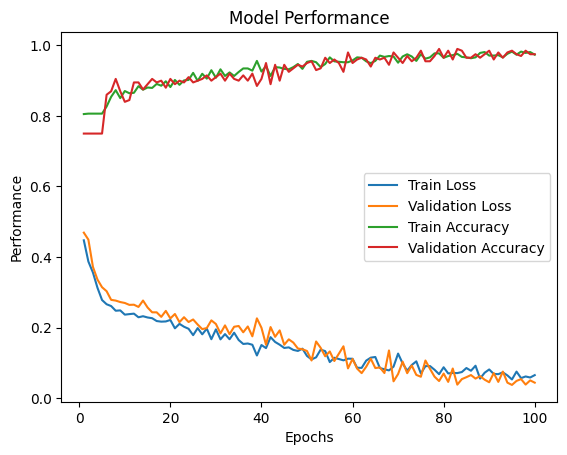

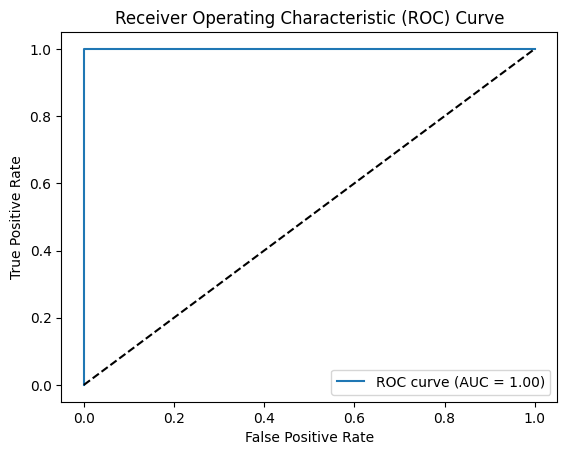

[I 2024-11-14 06:18:35,020] Trial 0 finished with value: 0.9051507586143441 and parameters: {'lstm_units_layer_0': 55, 'lstm_dropout_layer_0': 0.6956357682193333, 'lstm_recurrent_dropout_layer_0': 0.2633145464076351, 'dense_units': 15}. Best is trial 0 with value: 0.9051507586143441.


TEST LOSS-------> 0.07246167957782745
TEST ACCURACY-------> 0.9718875288963318
1/1 [==============================] - 1s 501ms/step
Done. The result of TensorFlow matches the result of TensorFlow Lite.
1/1 [==============================] - 0s 24ms/step
Done. The result of TensorFlow matches the result of TensorFlow Lite.
1/1 [==============================] - 0s 22ms/step
Done. The result of TensorFlow matches the result of TensorFlow Lite.
1/1 [==============================] - 0s 21ms/step
Done. The result of TensorFlow matches the result of TensorFlow Lite.
1/1 [==============================] - 0s 26ms/step
Done. The result of TensorFlow matches the result of TensorFlow Lite.
1/1 [==============================] - 0s 22ms/step
Done. The result of TensorFlow matches the result of TensorFlow Lite.
1/1 [==============================] - 0s 23ms/step
Done. The result of TensorFlow matches the result of TensorFlow Lite.
1/1 [==============================] - 0s 24ms/step
Done. The resu

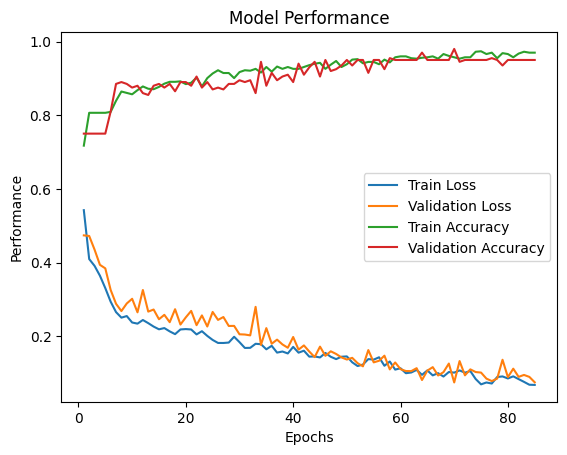

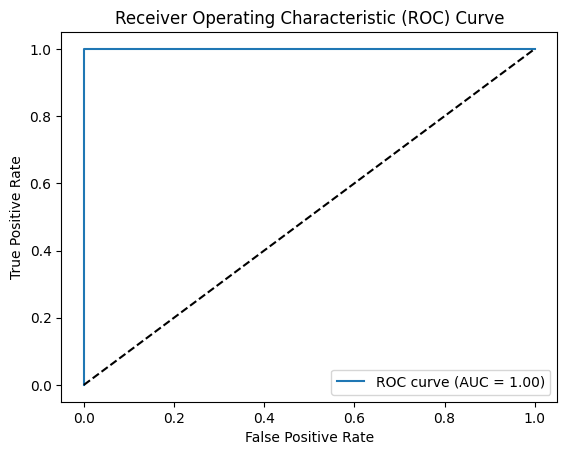

[I 2024-11-14 06:20:30,656] Trial 1 finished with value: 0.9230546605278243 and parameters: {'lstm_units_layer_0': 132, 'lstm_dropout_layer_0': 0.6234003031721583, 'lstm_recurrent_dropout_layer_0': 0.7986350638574709, 'dense_units': 38}. Best is trial 1 with value: 0.9230546605278243.


TEST LOSS-------> 0.0009214623714797199
TEST ACCURACY-------> 1.0
1/1 [==============================] - 1s 529ms/step
Done. The result of TensorFlow matches the result of TensorFlow Lite.
1/1 [==============================] - 0s 22ms/step
Done. The result of TensorFlow matches the result of TensorFlow Lite.
1/1 [==============================] - 0s 20ms/step
Done. The result of TensorFlow matches the result of TensorFlow Lite.
1/1 [==============================] - 0s 23ms/step
Done. The result of TensorFlow matches the result of TensorFlow Lite.
1/1 [==============================] - 0s 20ms/step
Done. The result of TensorFlow matches the result of TensorFlow Lite.
1/1 [==============================] - 0s 20ms/step
Done. The result of TensorFlow matches the result of TensorFlow Lite.
1/1 [==============================] - 0s 21ms/step
Done. The result of TensorFlow matches the result of TensorFlow Lite.
1/1 [==============================] - 0s 18ms/step
Done. The result of TensorF

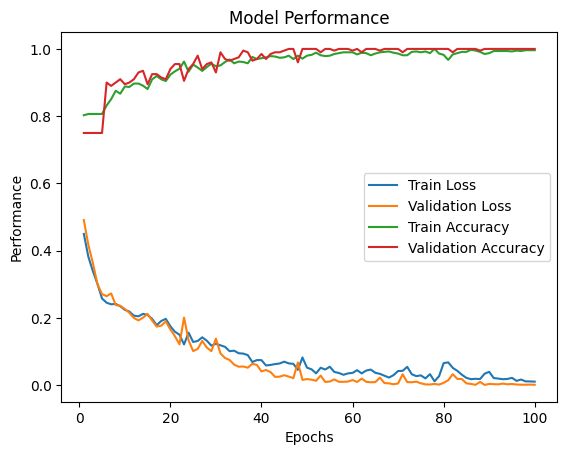

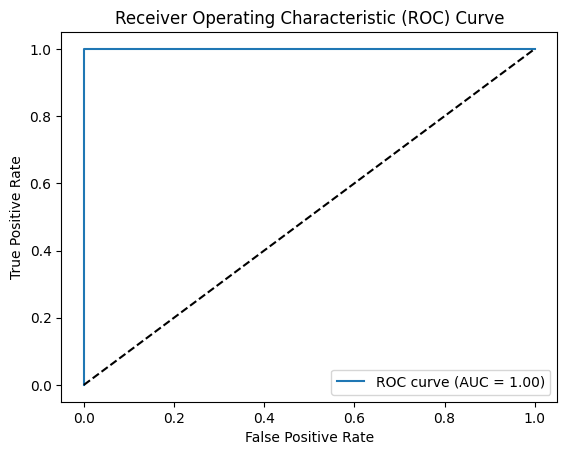

[I 2024-11-14 06:21:52,672] Trial 2 finished with value: 0.990760625398121 and parameters: {'lstm_units_layer_0': 78, 'lstm_dropout_layer_0': 0.27137953190573144, 'lstm_recurrent_dropout_layer_0': 0.4839701483941567, 'dense_units': 12}. Best is trial 2 with value: 0.990760625398121.


TEST LOSS-------> 0.010238943621516228
TEST ACCURACY-------> 0.9959839582443237
1/1 [==============================] - 1s 566ms/step
Done. The result of TensorFlow matches the result of TensorFlow Lite.
1/1 [==============================] - 0s 31ms/step
Done. The result of TensorFlow matches the result of TensorFlow Lite.
1/1 [==============================] - 0s 28ms/step
Done. The result of TensorFlow matches the result of TensorFlow Lite.
1/1 [==============================] - 0s 28ms/step
Done. The result of TensorFlow matches the result of TensorFlow Lite.
1/1 [==============================] - 0s 34ms/step
Done. The result of TensorFlow matches the result of TensorFlow Lite.
1/1 [==============================] - 0s 28ms/step
Done. The result of TensorFlow matches the result of TensorFlow Lite.
1/1 [==============================] - 0s 29ms/step
Done. The result of TensorFlow matches the result of TensorFlow Lite.
1/1 [==============================] - 0s 32ms/step
Done. The res

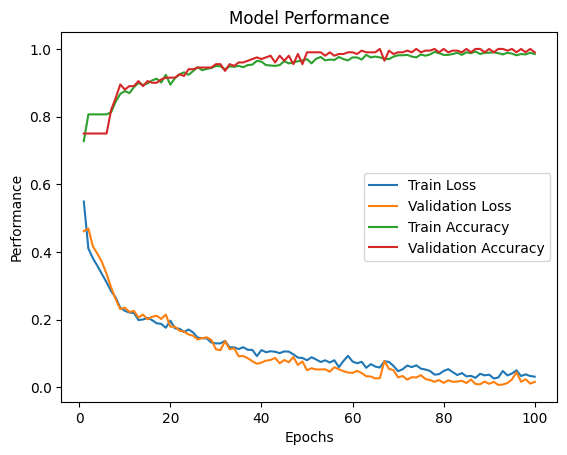

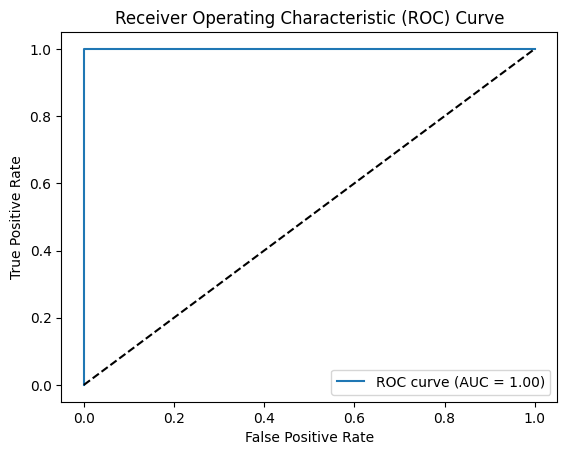

[I 2024-11-14 06:23:08,276] Trial 3 finished with value: 0.9761659833854316 and parameters: {'lstm_units_layer_0': 29, 'lstm_dropout_layer_0': 0.2343941621447799, 'lstm_recurrent_dropout_layer_0': 0.6031634584239653, 'dense_units': 41}. Best is trial 2 with value: 0.990760625398121.


TEST LOSS-------> 0.14060282707214355
TEST ACCURACY-------> 0.9437751173973083
1/1 [==============================] - 0s 401ms/step
Done. The result of TensorFlow matches the result of TensorFlow Lite.
1/1 [==============================] - 0s 22ms/step
Done. The result of TensorFlow matches the result of TensorFlow Lite.
1/1 [==============================] - 0s 25ms/step
Done. The result of TensorFlow matches the result of TensorFlow Lite.
1/1 [==============================] - 0s 34ms/step
Done. The result of TensorFlow matches the result of TensorFlow Lite.
1/1 [==============================] - 0s 24ms/step
Done. The result of TensorFlow matches the result of TensorFlow Lite.
1/1 [==============================] - 0s 21ms/step
Done. The result of TensorFlow matches the result of TensorFlow Lite.
1/1 [==============================] - 0s 22ms/step
Done. The result of TensorFlow matches the result of TensorFlow Lite.
1/1 [==============================] - 0s 18ms/step
Done. The resu

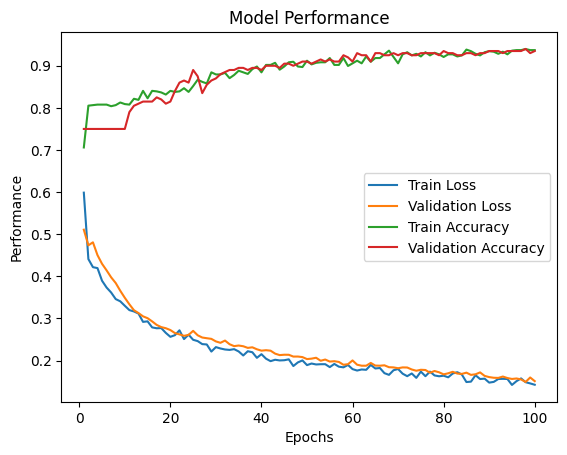

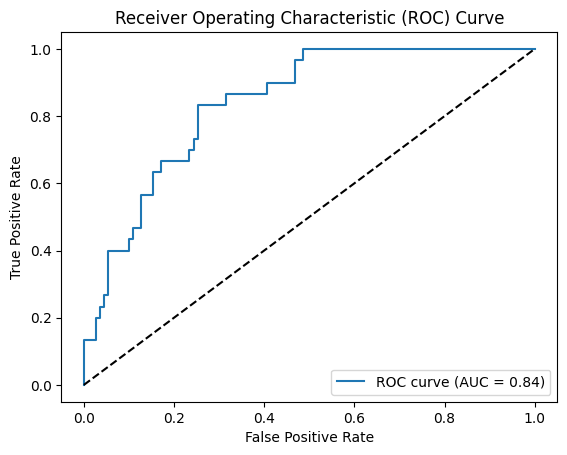

[I 2024-11-14 06:24:24,253] Trial 4 finished with value: 0.7458381176263362 and parameters: {'lstm_units_layer_0': 15, 'lstm_dropout_layer_0': 0.5096350017838698, 'lstm_recurrent_dropout_layer_0': 0.889618277043439, 'dense_units': 35}. Best is trial 2 with value: 0.990760625398121.


Best Hyperparameters:
  lstm_units_layer_0: 78
  lstm_dropout_layer_0: 0.27137953190573144
  lstm_recurrent_dropout_layer_0: 0.4839701483941567
  dense_units: 12
Best Accuracy: 0.990760625398121


In [ ]:
# THIS IS RNN LSTM
# NEW PLAN! NO AUGMENTATION!
# "You have control over your training set, but not over the real world or the process of collecting real data. "
# cost sensitive learning


# To summarize, setting return_sequences=False in an LSTM layer allows you to obtain a single output that summarizes the
# entire sequence, which can be useful for tasks where you want to make a single prediction or classification
# based on the entire input sequence.

# REMEMBER! USE THE  RETURN SEQUENCE = FALSE
import optuna

best_combined_metric = 0

best_model_tflite = ""
best_model = ""


X_train = []
X_test = []

y_test = []
y_train = []

rand_batches = []

positive_data = []
negative_data = []

checking_input_negative = []
checking_input_positive = []


def create_lstm_model(trial,input):
    global X_train

    model = Sequential()

    num_lstm_layers = 1

# constructing of layer based on Optuna
    for i in range(num_lstm_layers):
        units = trial.suggest_int(f'lstm_units_layer_{i}', 15, 150)
        dropout_rate_value = round(trial.suggest_float(f'lstm_dropout_layer_{i}', 0.0, 0.9)  , 2)
        recurrent_dropout_rate_value = round(trial.suggest_float(f'lstm_recurrent_dropout_layer_{i}', 0.0, 0.9), 2)

        model.add(Bidirectional(LSTM(units, return_sequences=False, activation='relu',
        dropout=dropout_rate_value, recurrent_dropout=recurrent_dropout_rate_value),
                  input_shape=(len(X_train[0]),len(X_train[0][0]))))

    # Dense layer
    dense_units = trial.suggest_int('dense_units', 10, 50)
    model.add(Dense(dense_units, activation='relu'))

    # Output layer
    model.add(Dense(1,activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model


def objective(trial):
    global best_combined_metric,best_model,best_model_tflite,X_test,y_test,X_train,y_train
    global rand_batches,positive_data,negative_data,checking_input_negative,checking_input_positive

    best_val_loss = 0

# weight influence of metric for loss and accuracy
    weight_loss = 0.5
    weight_accuracy = 0.5

# model creation and seting of hyperparameter
    model = create_lstm_model(trial,y_train)

# early stopping initialization
    custom_early_stopping = EarlyStopping(monitor='val_loss',patience=15,restore_best_weights=True)

# learning reduction initialization
    lr_reduction_callback = ReduceLROnPlateau( monitor='val_loss',factor=0.5,patience=10,min_lr=1e-6)

# converting to int
    y_train_int = y_train.astype(int)
    y_test_int = y_test.astype(int)

# model training
    history = model.fit(X_train, y_train, epochs=100, batch_size=124, validation_split=0.2, callbacks=[custom_early_stopping, lr_reduction_callback],verbose = 0)

# model metrics
    test_loss, test_accuracy = model.evaluate(X_test, y_test_int, verbose=0)
    print("TEST LOSS------->",test_loss)
    print("TEST ACCURACY------->",test_accuracy)


# objective value : calculating of metric with the predetermined weights
    combined_metric = weight_loss * (1 -test_loss) + weight_accuracy * test_accuracy

# converting of data
    temp = rand_batches[0].astype(np.float32)

# assigning of name ( this is to easily track for experimentation)
    id_num = str(rand.randint(1000,9999))

# model saving
    model.save('testingModel')

# converting of model to tflite
    file_saved_path = convert_tf_to_tflite('/content/testingModel',[1,len(positive_data[0]),len(positive_data[0][0])], temp,'whole_model',id_num,test_loss,test_accuracy)

# input checking
    checking_input_value = checking_inputs(checking_input_positive,checking_input_negative,file_saved_path)

# objective value : calculalting of checking input value
    combined_metric = combined_metric * 0.5 + checking_input_value * 0.5

# model performance analysis
    good_fit_graph(history)
    roc_curve_graph(checking_input_positive,checking_input_negative,file_saved_path)

# replacing saved model if it is outperformed
    if best_combined_metric <= combined_metric:
      if best_model_tflite is not None and os.path.exists(best_model_tflite):
          print("replacing-->", best_model_tflite)
          os.remove(best_model_tflite)
          best_model_tflite = file_saved_path
          best_combined_metric = combined_metric
          print("replaced with-->", best_model_tflite)
      elif best_model_tflite is None:
          print("still empty model-->", best_model_tflite)
          best_model_tflite = file_saved_path
          best_combined_metric = combined_metric
    else:
      if os.path.exists(file_saved_path):
          os.remove(file_saved_path)

    best_model = None
    return combined_metric





def training_main(raw_positive,raw_negative,raw_noise):
  global y_train,y_test,X_train,X_test,positive_data,negative_data
  global rand_batches,checking_input_negative,checking_input_positive

  best_val_loss = float('inf')
  best_val_accuracy = 0.0
  correctDataAugmentation_final = []
  best_combined_metric = 0
  best_model_tflite =""

  correct_data = raw_positive[0]
  incorrect_data = raw_negative[0]
  noise_data = raw_noise[0]

# outlier detection
  correct_data_common = common_length_sequence(correct_data,int(len(correct_data)*0.1))

# Padding of positive data
  correct_data_padded = paddingV2(correct_data_common)

# padding of negative data
  incorrect_data_padded = paddingV2(incorrect_data,len(correct_data_padded[0]))

# noise data augmentation
  noise_compiled = noise_compile(noise_data,len(correct_data_padded[0]))

# data augmentation : combining noise data and negative
  negative_data = np.concatenate((noise_compiled, incorrect_data_padded))

  positive_data = correct_data_padded

# Data partitioning : data that will be used for performance checking
  checking_input_positive = positive_data[int(len(positive_data)*.9):len(positive_data)]
  checking_input_negative = negative_data[int(len(negative_data)*.9):len(negative_data)]

# Data partitioning : data for model training
  positive_data = positive_data[0:int(len(positive_data)*.89)]
  negative_data = negative_data[0:int(len(negative_data)*.89)]

# labeling
  negative_label = np.zeros(len(negative_data))
  positive_label = np.ones(len(positive_data))

# Randomizing order of input and label
  rand_batches=concatenate_randomize_batches(positive_data,positive_label,negative_data,negative_label)

# Data partitioning: data for training and testing
  X_train, X_test, y_train, y_test = train_test_split(rand_batches[0], rand_batches[1], test_size=0.2, random_state=42)
  X_train = X_train.reshape(-1,len(X_train[0]),len(X_train[0][0]))


# Hyperparameter optimization : specifying parameter range
  study = optuna.create_study(direction='maximize')

# Hyperparameter optimization : training loop until best parameter is achieved
  study.optimize(objective, n_trials=5)

# Results:
  best_trial = study.best_trial
  print("Best Hyperparameters:")
  for key, value in best_trial.params.items():
      print(f"  {key}: {value}")
  print("Best Accuracy:", best_trial.value)





raw_positive = txt_pre_process('/content/drive/MyDrive/Colab Notebooks/rise(correct).txt',1,True,4)
raw_negative = txt_pre_process('/content/drive/MyDrive/Colab Notebooks/rise(incorrect).txt',0,True,4)
raw_noise = txt_pre_process('/content/drive/MyDrive/Colab Notebooks/noiseData1.txt',0,True,4)

training_main(raw_positive,raw_negative,raw_noise)





In [ ]:
# TRYING OUT RNN
import optuna

best_combined_metric = 0

best_model_tflite = ""
best_model = ""


X_train = []
X_test = []

y_test = []
y_train = []

rand_batches = []

positive_data = []
negative_data = []

checking_input_negative = []
checking_input_positive = []

def create_rnn_model(trial, input_shape):
    model = Sequential()

    num_rnn_layers = 1

    # Constructing layers based on Optuna
    for i in range(num_rnn_layers):
        units = trial.suggest_int(f'rnn_units_layer_{i}', 15, 150)
        dropout_rate_value = round(trial.suggest_float(f'rnn_dropout_layer_{i}', 0.0, 0.9), 2)
        recurrent_dropout_rate_value = round(trial.suggest_float(f'rnn_recurrent_dropout_layer_{i}', 0.0, 0.9), 2)

        model.add(SimpleRNN(units, return_sequences=False, activation='relu',
                            dropout=dropout_rate_value, recurrent_dropout=recurrent_dropout_rate_value))

    # Dense layer
    dense_units = trial.suggest_int('dense_units', 10, 50)
    model.add(Dense(dense_units, activation='relu'))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model



def objective(trial):
    global best_combined_metric,best_model,best_model_tflite,X_test,y_test,X_train,y_train
    global rand_batches,positive_data,negative_data,checking_input_negative,checking_input_positive

    best_val_loss = 0

# weight influence of metric for loss and accuracy
    weight_loss = 0.5
    weight_accuracy = 0.5

# model creation and seting of hyperparameter
    model = create_cnn_model(trial,y_train)

# early stopping initialization
    custom_early_stopping = EarlyStopping(monitor='val_loss',patience=15,restore_best_weights=True)

# learning reduction initialization
    lr_reduction_callback = ReduceLROnPlateau( monitor='val_loss',factor=0.5,patience=10,min_lr=1e-6)

# converting to int
    y_train_int = y_train.astype(int)
    y_test_int = y_test.astype(int)

# model training
    history = model.fit(X_train, y_train, epochs=100, batch_size=124, validation_split=0.2, callbacks=[custom_early_stopping, lr_reduction_callback],verbose = 0)

# model metrics
    test_loss, test_accuracy = model.evaluate(X_test, y_test_int, verbose=0)
    print("TEST LOSS------->",test_loss)
    print("TEST ACCURACY------->",test_accuracy)


# objective value : calculating of metric with the predetermined weights
    combined_metric = weight_loss * (1 -test_loss) + weight_accuracy * test_accuracy

# converting of data
    temp = rand_batches[0].astype(np.float32)

# assigning of name ( this is to easily track for experimentation)
    id_num = str(rand.randint(1000,9999))

# model saving
    model.save('testingModel')

# converting of model to tflite
    file_saved_path = convert_tf_to_tflite('/content/testingModel',[1,len(positive_data[0]),len(positive_data[0][0])], temp,'whole_model',id_num,test_loss,test_accuracy)

# input checking
    checking_input_value = checking_inputs(checking_input_positive,checking_input_negative,file_saved_path)

# objective value : calculalting of checking input value
    combined_metric = combined_metric * 0.5 + checking_input_value * 0.5

# model performance analysis
    good_fit_graph(history)
    roc_curve_graph(checking_input_positive,checking_input_negative,file_saved_path)

# replacing saved model if it is outperformed
    if best_combined_metric <= combined_metric:
      if best_model_tflite is not None and os.path.exists(best_model_tflite):
          print("replacing-->", best_model_tflite)
          os.remove(best_model_tflite)
          best_model_tflite = file_saved_path
          best_combined_metric = combined_metric
          print("replaced with-->", best_model_tflite)
      elif best_model_tflite is None:
          print("still empty model-->", best_model_tflite)
          best_model_tflite = file_saved_path
          best_combined_metric = combined_metric
    else:
      if os.path.exists(file_saved_path):
          os.remove(file_saved_path)

    best_model = None
    return combined_metric





def training_main(raw_positive,raw_negative,raw_noise):
  global y_train,y_test,X_train,X_test,positive_data,negative_data
  global rand_batches,checking_input_negative,checking_input_positive

  best_val_loss = float('inf')
  best_val_accuracy = 0.0
  correctDataAugmentation_final = []
  best_combined_metric = 0
  best_model_tflite =""

  correct_data = raw_positive[0]
  incorrect_data = raw_negative[0]
  noise_data = raw_noise[0]

# outlier detection
  correct_data_common = common_length_sequence(correct_data,int(len(correct_data)*0.1))

# Padding of positive data
  correct_data_padded = paddingV2(correct_data_common)

# padding of negative data
  incorrect_data_padded = paddingV2(incorrect_data,len(correct_data_padded[0]))

# noise data augmentation
  noise_compiled = noise_compile(noise_data,len(correct_data_padded[0]))

# data augmentation : combining noise data and negative
  negative_data = np.concatenate((noise_compiled, incorrect_data_padded))

  positive_data = correct_data_padded

# Data partitioning : data that will be used for performance checking
  checking_input_positive = positive_data[int(len(positive_data)*.9):len(positive_data)]
  checking_input_negative = negative_data[int(len(negative_data)*.9):len(negative_data)]

# Data partitioning : data for model training
  positive_data = positive_data[0:int(len(positive_data)*.89)]
  negative_data = negative_data[0:int(len(negative_data)*.89)]

# labeling
  negative_label = np.zeros(len(negative_data))
  positive_label = np.ones(len(positive_data))

# Randomizing order of input and label
  rand_batches=concatenate_randomize_batches(positive_data,positive_label,negative_data,negative_label)

# Data partitioning: data for training and testing
  X_train, X_test, y_train, y_test = train_test_split(rand_batches[0], rand_batches[1], test_size=0.2, random_state=42)
  X_train = X_train.reshape(-1,len(X_train[0]),len(X_train[0][0]))


# Hyperparameter optimization : specifying parameter range
  study = optuna.create_study(direction='maximize')

# Hyperparameter optimization : training loop until best parameter is achieved
  study.optimize(objective, n_trials=5)

# Results:
  best_trial = study.best_trial
  print("Best Hyperparameters:")
  for key, value in best_trial.params.items():
      print(f"  {key}: {value}")
  print("Best Accuracy:", best_trial.value)





raw_positive = txt_pre_process('/content/drive/MyDrive/Colab Notebooks/obliqueCompiled.txt',1,True,4)
raw_negative = txt_pre_process('/content/drive/MyDrive/Colab Notebooks/obliqueTwistIncorrect.txt',0,True,4)
# raw_negative = txt_pre_process('/content/drive/MyDrive/Colab Notebooks/incorrectDataNoContent.txt',0,True,4)


raw_noise = txt_pre_process('/content/drive/MyDrive/Colab Notebooks/noiseData1.txt',0,True,4)

training_main(raw_positive,raw_negative,raw_noise)





[I 2024-05-16 20:49:15,765] A new study created in memory with name: no-name-f1ef1ee7-3f94-45ee-8315-d127800039a9
[W 2024-05-16 20:49:15,766] Trial 0 failed with parameters: {} because of the following error: NameError("name 'create_cnn_model' is not defined").
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-5-a6c085c77ce4>", line 63, in objective
    model = create_cnn_model(trial,y_train)
NameError: name 'create_cnn_model' is not defined
[W 2024-05-16 20:49:15,769] Trial 0 failed with value None.


Most Common Data Points: [7, 8, 6]
Outlier Frequencies: [24, 3, 1, 9, 19, 20, 10, 5, 17, 2, 4]
-------------------applied frequency outlier detection-------------------
original num ->  277
current num ->  228
removed num ->  49
------------------------applied paddingV2------------------------
max_length ->  8
expanded_max_length ->  8
original num set of sequences ->  228
final num set of sequences ->  392
------------------------applied paddingV2------------------------
max_length ->  0
expanded_max_length ->  8
original num set of sequences ->  122
final num set of sequences ->  309


NameError: name 'create_cnn_model' is not defined

In [ ]:
import tensorflow as tf

def fgsm_attack(model, data, target, epsilon):
    # Use GradientTape for automatic differentiation
    with tf.GradientTape() as tape:
        tape.watch(data)
        prediction = model(data)
        loss = tf.keras.losses.sparse_categorical_crossentropy(target, prediction)

    # Compute gradients of the loss with respect to the data
    gradient = tape.gradient(loss, data)

    # Generate adversarial example by adding perturbation
    perturbed_data = data + epsilon * tf.sign(gradient)

    # Clip to [0,1] range
    perturbed_data = tf.clip_by_value(perturbed_data, 0, 1)

    return perturbed_data


In [ ]:
# TRYING OUT CNN
import optuna

best_combined_metric = 0

best_model_tflite = ""
best_model = ""


X_train = []
X_test = []

y_test = []
y_train = []

rand_batches = []

positive_data = []
negative_data = []

checking_input_negative = []
checking_input_positive = []



def create_tcn_model(trial, input_shape):
    model = Sequential()

    num_tcn_layers = 1  # Example number of TCN layers

    # Constructing TCN layers based on Optuna
    for i in range(num_tcn_layers):
        filters = trial.suggest_int(f'tcn_filters_layer_{i}', 8, 64)
        kernel_size = trial.suggest_int(f'tcn_kernel_size_layer_{i}', 2, 5)
        dilation_rate = 2 ** i  # Use exponential increase in dilation rate

        model.add(Conv1D(filters=filters, kernel_size=kernel_size, dilation_rate=dilation_rate,
                         padding='causal', activation='relu'))

    # Flatten layer to transition from convolutional layers to fully connected layers
    model.add(Flatten())

    # Dense layers
    dense_units = trial.suggest_int('dense_units', 10, 50)
    model.add(Dense(dense_units, activation='relu'))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    return model


def objective(trial):
    global best_combined_metric,best_model,best_model_tflite,X_test,y_test,X_train,y_train
    global rand_batches,positive_data,negative_data,checking_input_negative,checking_input_positive

    best_val_loss = 0

# weight influence of metric for loss and accuracy
    weight_loss = 0.5
    weight_accuracy = 0.5

# model creation and seting of hyperparameter
    model = create_tcn_model(trial,y_train)

# early stopping initialization
    custom_early_stopping = EarlyStopping(monitor='val_loss',patience=15,restore_best_weights=True)

# learning reduction initialization
    lr_reduction_callback = ReduceLROnPlateau( monitor='val_loss',factor=0.5,patience=10,min_lr=1e-6)

# converting to int
    y_train_int = y_train.astype(int)
    y_test_int = y_test.astype(int)

# model training
# original working epoch = 100
# trying out epoch [50]
    history = model.fit(X_train, y_train, epochs=50, batch_size=124, validation_split=0.2, callbacks=[custom_early_stopping, lr_reduction_callback],verbose = 0)

# model metrics
    test_loss, test_accuracy = model.evaluate(X_test, y_test_int, verbose=0)
    print("TEST LOSS------->",test_loss)
    print("TEST ACCURACY------->",test_accuracy)


# objective value : calculating of metric with the predetermined weights
    combined_metric = weight_loss * (1 -test_loss) + weight_accuracy * test_accuracy

# converting of data
    temp = rand_batches[0].astype(np.float32)

# assigning of name ( this is to easily track for experimentation)
    id_num = str(rand.randint(1000,9999))

# model saving
    model.save('testingModel.keras')



# converting of model to tflite
    file_saved_path = convert_tf_to_tflite('/content/testingModel.h5',[1,len(positive_data[0]),len(positive_data[0][0])], temp,'whole_model',id_num,test_loss,test_accuracy)

# input checking
    checking_input_value = checking_inputs(checking_input_positive,checking_input_negative,file_saved_path)

# objective value : calculalting of checking input value
    combined_metric = combined_metric * 0.5 + checking_input_value * 0.5

# model performance analysis
    good_fit_graph(history)
    roc_curve_graph(checking_input_positive,checking_input_negative,file_saved_path)

# replacing saved model if it is outperformed
    if best_combined_metric <= combined_metric:
      if best_model_tflite is not None and os.path.exists(best_model_tflite):
          print("replacing-->", best_model_tflite)
          os.remove(best_model_tflite)
          best_model_tflite = file_saved_path
          best_combined_metric = combined_metric
          print("replaced with-->", best_model_tflite)
      elif best_model_tflite is None:
          print("still empty model-->", best_model_tflite)
          best_model_tflite = file_saved_path
          best_combined_metric = combined_metric
    else:
      if os.path.exists(file_saved_path):
          os.remove(file_saved_path)

    best_model = None
    return combined_metric

def training_main(raw_positive,raw_negative,raw_noise):
  global y_train,y_test,X_train,X_test,positive_data,negative_data
  global rand_batches,checking_input_negative,checking_input_positive

  best_val_loss = float('inf')
  best_val_accuracy = 0.0
  correctDataAugmentation_final = []
  best_combined_metric = 0
  best_model_tflite =""

  correct_data = raw_positive[0]
  incorrect_data = raw_negative[0]
  noise_data = raw_noise[0]

# outlier detection
  correct_data_common = common_length_sequence(correct_data,int(len(correct_data)*0.1))

# Padding of positive data
  correct_data_padded = paddingV2(correct_data_common)

# padding of negative data
  incorrect_data_padded = paddingV2(incorrect_data,len(correct_data_padded[0]))

# noise data augmentation
  noise_compiled = noise_compile(noise_data,len(correct_data_padded[0]))

# data augmentation : combining noise data and negative
  negative_data = np.concatenate((noise_compiled, incorrect_data_padded))

  positive_data = correct_data_padded

# Data partitioning : data that will be used for performance checking
  checking_input_positive = positive_data[int(len(positive_data)*.9):len(positive_data)]
  checking_input_negative = negative_data[int(len(negative_data)*.9):len(negative_data)]

# Data partitioning : data for model training
  positive_data = positive_data[0:int(len(positive_data)*.89)]
  negative_data = negative_data[0:int(len(negative_data)*.89)]

# labeling
  negative_label = np.zeros(len(negative_data))
  positive_label = np.ones(len(positive_data))

# Randomizing order of input and label
  rand_batches=concatenate_randomize_batches(positive_data,positive_label,negative_data,negative_label)

# Data partitioning: data for training and testing
  X_train, X_test, y_train, y_test = train_test_split(rand_batches[0], rand_batches[1], test_size=0.2, random_state=42)
  X_train = X_train.reshape(-1,len(X_train[0]),len(X_train[0][0]))


# Hyperparameter optimization : specifying parameter range
  study = optuna.create_study(direction='maximize')

# Hyperparameter optimization : training loop until best parameter is achieved
  study.optimize(objective, n_trials=25)

# Results:
  best_trial = study.best_trial
  print("Best Hyperparameters:")
  for key, value in best_trial.params.items():
      print(f"  {key}: {value}")
  print("Best Accuracy:", best_trial.value)

raw_positive = txt_pre_process('/content/drive/MyDrive/Colab Notebooks/obliqueCompiled.txt',1,True,4)
raw_negative = txt_pre_process('/content/drive/MyDrive/Colab Notebooks/obliqueTwistIncorrect.txt',0,True,4)
# raw_negative = txt_pre_process('/content/drive/MyDrive/Colab Notebooks/incorrectDataNoContent.txt',0,True,4)

raw_noise = txt_pre_process('/content/drive/MyDrive/Colab Notebooks/noiseData1.txt',0,True,4)

training_main(raw_positive,raw_negative,raw_noise)





[I 2024-11-14 06:12:37,669] A new study created in memory with name: no-name-7ec4eab5-8b76-4f67-ac1d-14403c632a76


Most Common Data Points: [7, 8, 6]
Outlier Frequencies: [24, 3, 1, 9, 19, 20, 10, 5, 17, 2, 4]
-------------------applied frequency outlier detection-------------------
original num ->  277
current num ->  228
removed num ->  49
------------------------applied paddingV2------------------------
max_length ->  8
expanded_max_length ->  8
original num set of sequences ->  228
final num set of sequences ->  392
------------------------applied paddingV2------------------------
max_length ->  0
expanded_max_length ->  8
original num set of sequences ->  122
final num set of sequences ->  309


[W 2024-11-14 06:12:46,769] Trial 0 failed with parameters: {'tcn_filters_layer_0': 34, 'tcn_kernel_size_layer_0': 2, 'dense_units': 11} because of the following error: ValueError('Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=keras_lstm.').
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-16-92d239279bd7>", line 105, in objective
    file_saved_path = convert_tf_to_tflite('/content/testingModel.h5',[1,len(positive_data[0]),len(positive_data[0][0])], temp,'whole_model',id_num,test_loss,test_accuracy)
  File "<ipython-input-15-eb0753deda25>", line 327, in convert_tf_to_tflite
    model.save(MODEL_DIR)
  File "/usr/local/lib/python3.10/d

TEST LOSS-------> 0.019079133868217468
TEST ACCURACY-------> 0.9970501661300659


ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=keras_lstm.

In [ ]:
# applying optuna to all parameters

import optuna

best_combined_metric = 0

best_model_tflite = ""
best_model = ""


X_train = []
X_test = []

y_test = []
y_train = []

rand_batches = []

positive_data = []
negative_data = []

checking_input_negative = []
checking_input_positive = []


def create_lstm_model(trial,input):
    global X_train

    model = Sequential()

    num_lstm_layers = 1

# constructing of layer based on Optuna
    for i in range(num_lstm_layers):
        units = trial.suggest_int(f'lstm_units_layer_{i}', 15, 150)
        dropout_rate_value = round(trial.suggest_float(f'lstm_dropout_layer_{i}', 0.0, 0.9)  , 2)
        recurrent_dropout_rate_value = round(trial.suggest_float(f'lstm_recurrent_dropout_layer_{i}', 0.0, 0.9), 2)

        print(f"units ->{units}")
        print(f"dropout_rate_value ->{dropout_rate_value}")
        print(f"recurrent_dropout_rate_value ->{recurrent_dropout_rate_value}")



        model.add(Bidirectional(LSTM(units, return_sequences=False, activation='relu',
        dropout=dropout_rate_value, recurrent_dropout=recurrent_dropout_rate_value),
                  input_shape=(len(X_train[0]),len(X_train[0][0]))))



    # Dense layer
    dense_units = trial.suggest_int('dense_units', 10, 50)
    model.add(Dense(dense_units, activation='relu'))

    # Output layer
    model.add(Dense(1,activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model


def objective(trial):
    global best_combined_metric,best_model,best_model_tflite,X_test,y_test,X_train,y_train
    global rand_batches,positive_data,negative_data,checking_input_negative,checking_input_positive

    best_val_loss = 0

# weight influence of metric for loss and accuracy
    weight_loss = 0.5
    weight_accuracy = 0.5

# model creation and seting of hyperparameter
    model = create_lstm_model(trial,y_train)

#epoch setting up(optuna)
    epochs = trial.suggest_int("epochs", 25, 100)
    print(f"epochs ->{epochs}")


#batch size setting up(optuna)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    print(f"batch_size ->{batch_size}")


# early stopping initialization
    custom_early_stopping = EarlyStopping(monitor='val_loss',patience=15,restore_best_weights=True)

# learning reduction initialization
    lr_reduction_callback = ReduceLROnPlateau( monitor='val_loss',factor=0.5,patience=10,min_lr=1e-6)

# converting to int
    y_train_int = y_train.astype(int)
    y_test_int = y_test.astype(int)

# model training
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[custom_early_stopping, lr_reduction_callback],verbose = 0)

# model metrics
    test_loss, test_accuracy = model.evaluate(X_test, y_test_int, verbose=0)
    print("TEST LOSS------->",test_loss)
    print("TEST ACCURACY------->",test_accuracy)


# objective value : calculating of metric with the predetermined weights
    combined_metric = weight_loss * (1 -test_loss) + weight_accuracy * test_accuracy

# converting of data
    temp = rand_batches[0].astype(np.float32)

# assigning of name ( this is to easily track for experimentation)
    id_num = str(rand.randint(1000,9999))

# model saving
    model.save('testingModel')

# converting of model to tflite
    file_saved_path = convert_tf_to_tflite('/content/testingModel',[1,len(positive_data[0]),len(positive_data[0][0])], temp,'whole_model',id_num,test_loss,test_accuracy)

# input checking
    checking_input_value = checking_inputs(checking_input_positive,checking_input_negative,file_saved_path)

# objective value : calculalting of checking input value
    combined_metric = combined_metric * 0.5 + checking_input_value * 0.5

# model performance analysis
    good_fit_graph(history)
    roc_curve_graph(checking_input_positive,checking_input_negative,file_saved_path)

# replacing saved model if it is outperformed
    if best_combined_metric <= combined_metric:
      if best_model_tflite is not None and os.path.exists(best_model_tflite):
          print("replacing-->", best_model_tflite)
          os.remove(best_model_tflite)
          best_model_tflite = file_saved_path
          best_combined_metric = combined_metric
          print("replaced with-->", best_model_tflite)
      elif best_model_tflite is None:
          print("still empty model-->", best_model_tflite)
          best_model_tflite = file_saved_path
          best_combined_metric = combined_metric
    else:
      if os.path.exists(file_saved_path):
          os.remove(file_saved_path)

    best_model = None
    return combined_metric



def training_main(raw_positive,raw_negative,raw_noise):
  global y_train,y_test,X_train,X_test,positive_data,negative_data
  global rand_batches,checking_input_negative,checking_input_positive

  best_val_loss = float('inf')
  best_val_accuracy = 0.0
  correctDataAugmentation_final = []
  best_combined_metric = 0
  best_model_tflite =""

  correct_data = raw_positive[0]
  incorrect_data = raw_negative[0]
  noise_data = raw_noise[0]

# outlier detection
  correct_data_common = common_length_sequence(correct_data,int(len(correct_data)*0.1))

# Padding of positive data
  correct_data_padded = paddingV2(correct_data_common)

# padding of negative data
  incorrect_data_padded = paddingV2(incorrect_data,len(correct_data_padded[0]))

# noise data augmentation
  noise_compiled = noise_compile(noise_data,len(correct_data_padded[0]))

# data augmentation : combining noise data and negative
  negative_data = np.concatenate((noise_compiled, incorrect_data_padded))

  positive_data = correct_data_padded

# Data partitioning : data that will be used for performance checking
  checking_input_positive = positive_data[int(len(positive_data)*.9):len(positive_data)]
  checking_input_negative = negative_data[int(len(negative_data)*.9):len(negative_data)]

# Data partitioning : data for model training
  positive_data = positive_data[0:int(len(positive_data)*.89)]
  negative_data = negative_data[0:int(len(negative_data)*.89)]

# labeling
  negative_label = np.zeros(len(negative_data))
  positive_label = np.ones(len(positive_data))

# Randomizing order of input and label
  rand_batches=concatenate_randomize_batches(positive_data,positive_label,negative_data,negative_label)

# Data partitioning: data for training and testing
  X_train, X_test, y_train, y_test = train_test_split(rand_batches[0], rand_batches[1], test_size=0.2, random_state=42)
  X_train = X_train.reshape(-1,len(X_train[0]),len(X_train[0][0]))


# Hyperparameter optimization : specifying parameter range
  study = optuna.create_study(direction='maximize')

# Hyperparameter optimization : training loop until best parameter is achieved
  study.optimize(objective, n_trials=5)

# Results:
  best_trial = study.best_trial
  print("Best Hyperparameters:")
  for key, value in best_trial.params.items():
      print(f"  {key}: {value}")
  print("Best Accuracy:", best_trial.value)





raw_positive = txt_pre_process('/content/drive/MyDrive/Colab Notebooks/rise(correct).txt',1,True,4)
raw_negative = txt_pre_process('/content/drive/MyDrive/Colab Notebooks/rise(incorrect).txt',0,True,4)
raw_noise = txt_pre_process('/content/drive/MyDrive/Colab Notebooks/noiseData1.txt',0,True,4)

training_main(raw_positive,raw_negative,raw_noise)





ModuleNotFoundError: No module named 'optuna'

In [ ]:
from tensorflow import keras
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Path to the TFLite model
model_path = '/content/drive/MyDrive/datasets/exercises/jumpingJacks/jumpingJacks.tflite'

# Load TFLite model as TFSMLayer
# layer = keras.layers.TFSMLayer(model_path, call_endpoint='serving_default')


print("TFSMLayer created successfully!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


OSError: SavedModel file does not exist at: /content/drive/MyDrive/datasets/exercises/jumpingJacks/jumpingJacks.tflite/{saved_model.pbtxt|saved_model.pb}

Input shape details: [{'name': 'serving_default_x:0', 'index': 0, 'shape': array([ 1,  9, 66], dtype=int32), 'shape_signature': array([ 1,  9, 66], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Expected input shape: [ 1  9 66]
Confusion Matrix:
[[2 0]
 [3 0]]


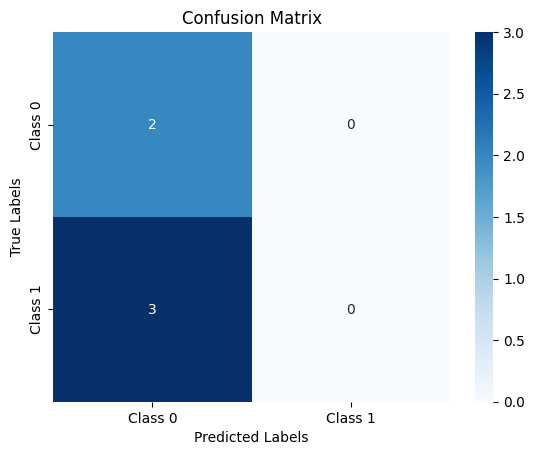

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Path to the TFLite model
model_path = '/content/drive/MyDrive/datasets/exercises/jumpingJacks/jumpingJacks.tflite'

# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Print input shape details to understand the required input shape
print("Input shape details:", input_details)

# Example input data (replace with your actual test dataset)
input_shape = input_details[0]['shape']
print("Expected input shape:", input_shape)

# Example: Correct input shape (ensure batch size of 1, i.e., shape (1, 9, 66))
# Replace with your actual test data, here using random data as a placeholder
input_data = np.random.random_sample((1, 9, 66)).astype(np.float32)  # Adjust shape based on model input details

# True labels (y_true) for the test dataset
# Replace with your actual labels
y_true = np.array([0, 1, 0, 1, 1])  # Example ground truth for testing

# Perform inference for each sample in the test set
y_pred = []

for i in range(len(y_true)):
    # Modify input_data to reflect a new test sample
    # Assuming input shape should be (1, 9, 66), so we reshape for each sample
    sample_input = np.random.random_sample(input_shape[1:]).astype(np.float32)  # Modify input for each sample
    sample_input = sample_input.reshape((1, 9, 66))  # Ensure correct shape for a single sample

    # Set the input tensor for inference
    interpreter.set_tensor(input_details[0]['index'], sample_input)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Get the predicted class (index with the highest score)
    predicted_class = np.argmax(output_data)
    y_pred.append(predicted_class)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix using a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
